In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import tensorflow_addons as tfa

from mlxtend.plotting import heatmap
import seaborn as sns
import pprint
import graphviz

import os
from IPython.display import display

pp = pprint.PrettyPrinter()

2023-04-09 20:28:54.604364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 20:28:55.510770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dramos/miniconda3/envs/w207_final/lib/
2023-04-09 20:28:55.510926: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dramos/miniconda3/envs/w207_final/lib/
2023-04-09 20:28:55.510936: W tensorfl

# Exploratory Data Analysis

### Load Data

In [2]:
# Get current working directory for repo
working_dir = os.getcwd()

# read the original / raw Occupancy_Estimation.csv data source
df = pd.read_csv(working_dir + '/data/raw/Occupancy_Estimation.csv')
df.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


### Prepocessing, Cleansing, Feature Engineering

In [3]:
# Check for NA values
print(df.isna().sum())

Date                    0
Time                    0
S1_Temp                 0
S2_Temp                 0
S3_Temp                 0
S4_Temp                 0
S1_Light                0
S2_Light                0
S3_Light                0
S4_Light                0
S1_Sound                0
S2_Sound                0
S3_Sound                0
S4_Sound                0
S5_CO2                  0
S5_CO2_Slope            0
S6_PIR                  0
S7_PIR                  0
Room_Occupancy_Count    0
dtype: int64


In [4]:
# ID original features and labels
print('Total number of columns:', len(df.columns))
features = df.columns[:18]
print('Original Features:', features)
label = [df.columns[-1]]
print('Original Label:', label)
print('Class labels:', df[label[0]].unique())
print('Original Shape:', df.shape)

Total number of columns: 19
Original Features: Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'],
      dtype='object')
Original Label: ['Room_Occupancy_Count']
Class labels: [1 2 3 0]
Original Shape: (10129, 19)


In [5]:
# Combine date and time into a single timestamp
timestamp = pd.to_datetime(df["Date"].astype(str) + df["Time"], format="%Y/%m/%d%H:%M:%S")

# Insert combined datetime into first column of df
df.insert(0, "Timestamp", timestamp)

# Drop previous date and time columns
df.drop(columns=["Date", "Time"], inplace=True)

# Add occupied bool as potential output for EDA only
df["Occupied"] = (df["Room_Occupancy_Count"] > 0).astype(int)

In [6]:
# Check counts of all features to ensure ==
df.count()

Timestamp               10129
S1_Temp                 10129
S2_Temp                 10129
S3_Temp                 10129
S4_Temp                 10129
S1_Light                10129
S2_Light                10129
S3_Light                10129
S4_Light                10129
S1_Sound                10129
S2_Sound                10129
S3_Sound                10129
S4_Sound                10129
S5_CO2                  10129
S5_CO2_Slope            10129
S6_PIR                  10129
S7_PIR                  10129
Room_Occupancy_Count    10129
Occupied                10129
dtype: int64

In [7]:
# Check data types of columns
df.dtypes

Timestamp               datetime64[ns]
S1_Temp                        float64
S2_Temp                        float64
S3_Temp                        float64
S4_Temp                        float64
S1_Light                         int64
S2_Light                         int64
S3_Light                         int64
S4_Light                         int64
S1_Sound                       float64
S2_Sound                       float64
S3_Sound                       float64
S4_Sound                       float64
S5_CO2                           int64
S5_CO2_Slope                   float64
S6_PIR                           int64
S7_PIR                           int64
Room_Occupancy_Count             int64
Occupied                         int64
dtype: object

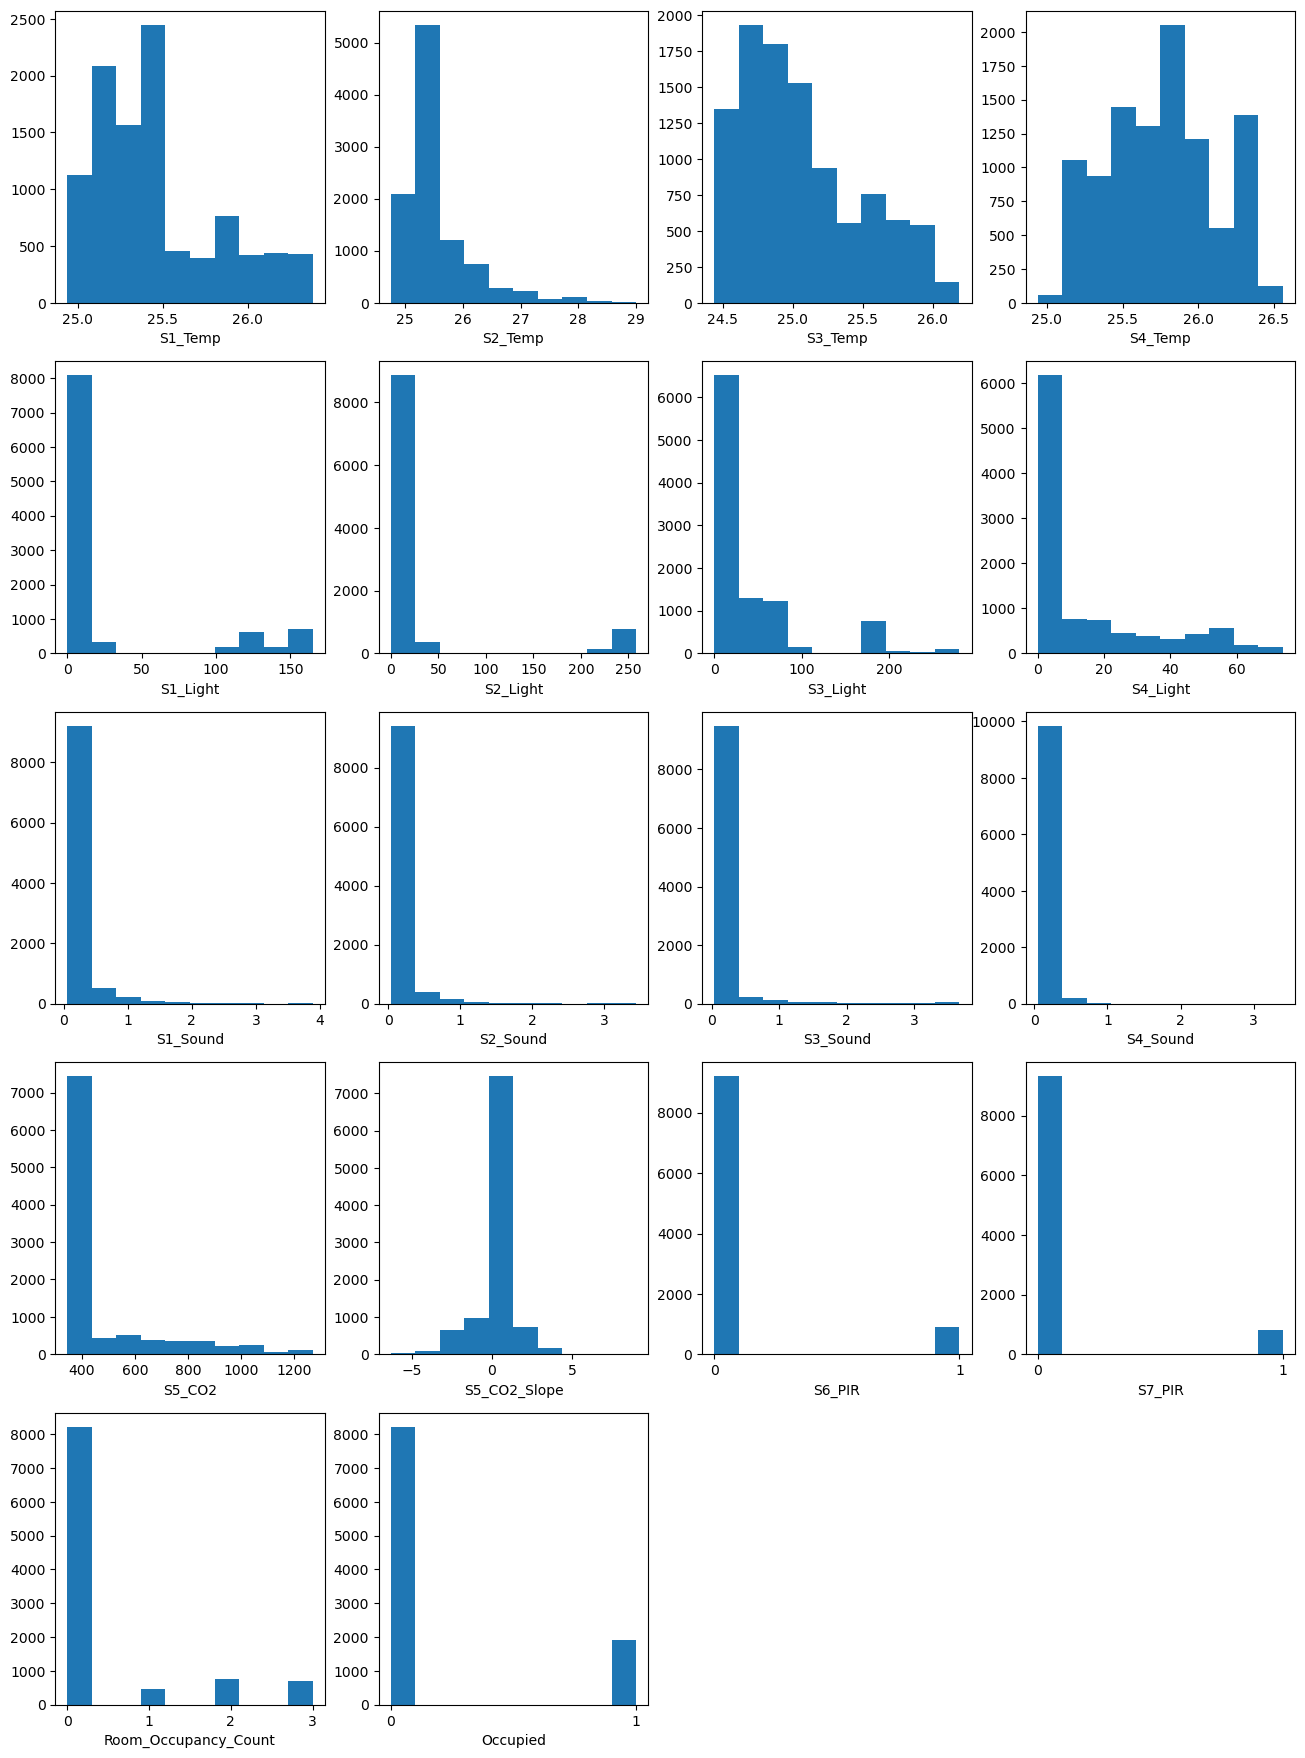

In [8]:
# Create Histograms for features to visualize distributions
columns = df.columns[1:]

fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16,22))
for idx, ax in enumerate(axes.flatten()):
    if idx >= len(columns):
        break
    # plot histogram
    ax.hist(df[columns[idx]])
    # set xlabel
    ax.set_xlabel(columns[idx])
axes[4][2].remove()
axes[4][3].remove()
axes[3][2].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
axes[3][3].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
axes[4][1].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

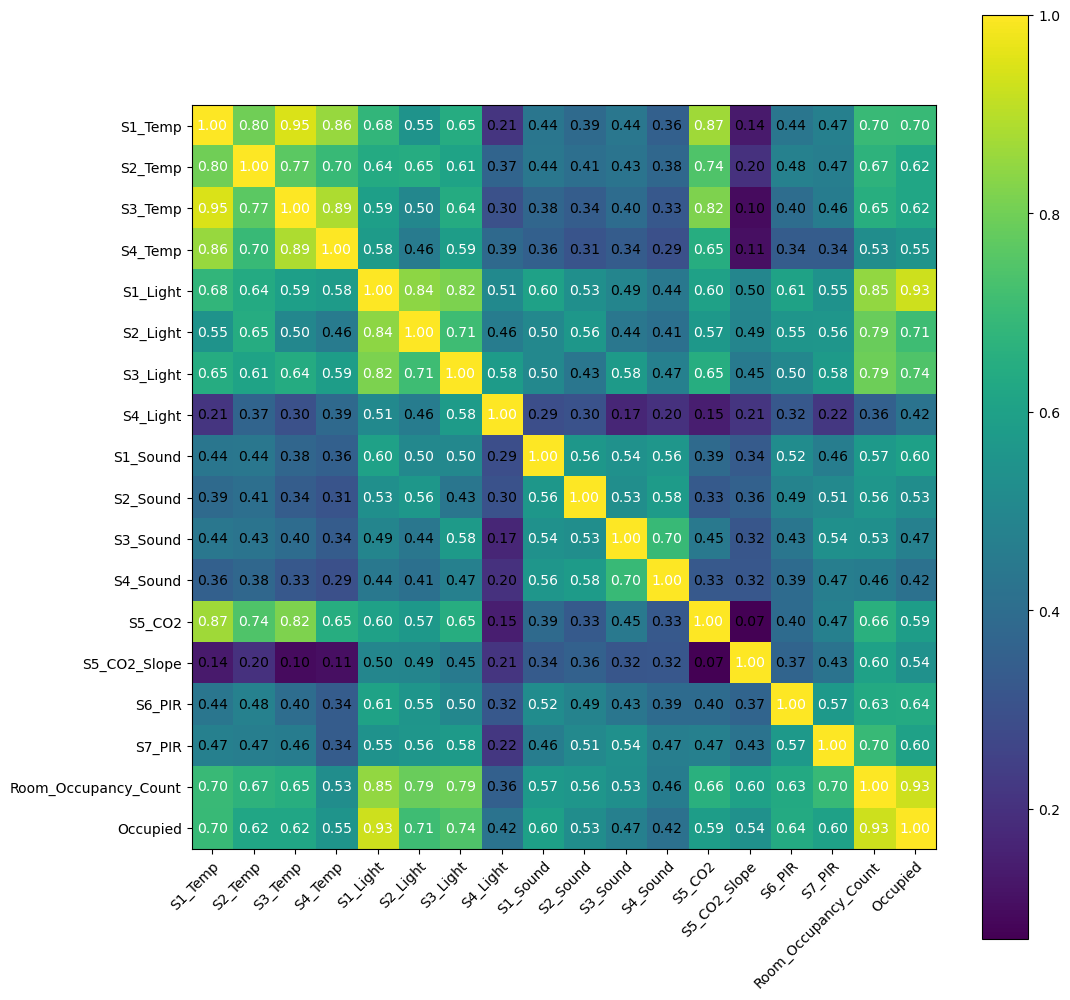

In [9]:
# Create correlation heat map to view correlations between features
columns = df.columns[1:]

cm = df[columns].corr().values 
hm = heatmap(
    cm,
    row_names=columns,
    column_names=columns,
    cmap='viridis',
    figsize=(12,12)
)

Min/Max Occupied Time: 10:49:41/19:51:46
Min/Max Unoccupied Time: 00:00:28/23:59:58
Total count of records after downsampling: 3590
Value counts for each class after downsampling:
0    1689
2     748
3     694
1     459
Name: Room_Occupancy_Count, dtype: int64


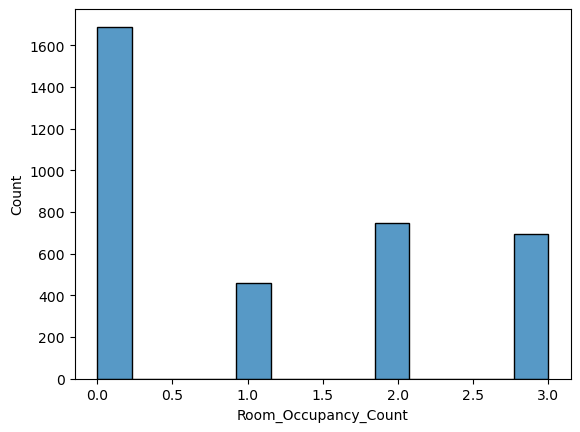

In [10]:
# Attempt to correct for class imbalance of Room_Occupancy_Count
# Downsample the majority class (Room_Occupancy_Count == 0)
# by keeping only records between the min_occupied_time and max_occupied_time 

# Define min and max occupied time
min_occupied_time = df[df["Room_Occupancy_Count"].ge(1)]["Timestamp"].dt.time.min()
max_occupied_time = df[df["Room_Occupancy_Count"].ge(1)]["Timestamp"].dt.time.max()

# Define min and max unoccupied time
min_unoccupied_time = df[df["Room_Occupancy_Count"] == 0]["Timestamp"].dt.time.min()
max_unoccupied_time = df[df["Room_Occupancy_Count"] == 0]["Timestamp"].dt.time.max()

print(f"Min/Max Occupied Time: {min_occupied_time}/{max_occupied_time}")
print(f"Min/Max Unoccupied Time: {min_unoccupied_time}/{max_unoccupied_time}")

# determine number of records remainging after downsampling the majority class
record_count_after_filter = df[df["Timestamp"].dt.time.between(min_occupied_time, max_occupied_time)]["Room_Occupancy_Count"].count()
print('Total count of records after downsampling:', record_count_after_filter)
room_occupancy_value_count_after_filter = df[df["Timestamp"].dt.time.between(min_occupied_time, max_occupied_time)]["Room_Occupancy_Count"].value_counts()
print('Value counts for each class after downsampling:')
print(room_occupancy_value_count_after_filter)

sns.histplot(df[df["Timestamp"].dt.time.between(min_occupied_time, max_occupied_time)]["Room_Occupancy_Count"])
plt.show()

# Model Pipeline

## Imports, Load Data, Preprocessing and Feature Engineering

### Imports

In [11]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker

import sklearn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

import tensorflow as tf
import tensorflow_addons as tfa

from mlxtend.plotting import heatmap
import seaborn as sns
import pprint
import graphviz

import os
from IPython.display import display
import itertools

pp = pprint.PrettyPrinter()

### Define helper functions

In [12]:
# Andre's function to split the dataset into train, validation, and test data
def split_data(X, y, split=(0.6, 0.2, 0.2), seed=888):
  """
  Splits X/y into training, validation, and testing sets based on the
  specified split.

  Parameters
  ----------
  X : np.ndarray
    An array-like collection of sample points
  y : np.ndarray
    The class labels of the data, should match the length of data
  split : tuple
    The percentage allocation of training, validation, and test datasets

  Returns
  -------
  splits : tuple
    The training, validation, and test datasets with their labels
    Defaults to a train/validation/test split of 60%/20%/20%
  """
  # Input checking
  if len(X) != len(y):
    raise ValueError(f"X and y lengths don't match ({len(X)} != {len(y)})")
  if len(split) != 3:
    raise ValueError("Invalid split, expected 3 percentages (training, validation, test)")
  if sum(split) != 1:
    raise ValueError(f"Invalid split {split}, percentages must sum to 1!")
  if not isinstance(X, np.ndarray) or not isinstance(y, np.ndarray):
    raise TypeError("X and y must be numpy arrays")

  # Initial split for testing data
  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
      X, y, test_size=split[2], random_state=seed, stratify=y)

  # Further split for validation data
  val_size = split[1] / (1 - split[2])
  X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
      X_train, y_train, test_size=val_size, random_state=seed, stratify=y_train)

  return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
# Andre's function to calculate specificities for each class
def calculate_f1_scores(true_labels, predicted_labels, labels=[0, 1, 2, 3], print_output=True):
    """
    Calculates the macro average f1-score, micro average f1-score, and weighted
    average f1-score from the given true and predicted labels

    Parameters
    ----------
    true_labels : np.ndarray
        An array-like collection of the true labels a model is trying to predict
    predicted_labels : np.ndarray
        An array-like collection of the predicted labels output from a model
    labels : list
        The set of unique class labels in the given classification problem
        Default: [0, 1, 2, 3]
    print_output : bool
        Whether to print the metrics out or not
        Default : True

    Returns
    -------
    macro_avg_f1 : float
        The macro average f1-score for the model. The function calculates the f1-score
        for each class individually and takes the unweighted mean of all values    
    micro_avg_f1 : float
        The micro average f1-score for the model. The function considers the total
        True Negatives (TN) and total False Positives (FP) amongst all classes and
        calculates the f1-score globally for the model
    weighted_avg_f1: float
        The support weighted average f1-score for the model. The function calculates
        the f1-score for each class individually and takes the weighted mean of all
        values based on the support of each class
    """

    # Calculate metrics
    macro_avg_f1 = sklearn.metrics.f1_score(true_labels, predicted_labels, labels=labels, average="macro")
    micro_avg_f1 = sklearn.metrics.f1_score(true_labels, predicted_labels, labels=labels, average="micro")
    weighted_avg_f1 = sklearn.metrics.f1_score(true_labels, predicted_labels, labels=labels, average="weighted")

    # Print metrics
    if print_output:
        print("F1-Scores")
        print("---------")
        print(f"Macro average: {macro_avg_f1:9.4f}")
        print(f"Micro average: {micro_avg_f1:9.4f}")
        print(f"Weighted average: {weighted_avg_f1:.4f}\n")

    return macro_avg_f1, micro_avg_f1, weighted_avg_f1

In [14]:
# Dakota's function to calculate specificities for each class
def calculate_specificities(true_labels, predicted_labels, labels=[0, 1, 2, 3]):
    """
    Calculates the macro average specificity, micro average specificity and weighted average specificity
    from the given true and predicted labels

    Parameters
    ----------
    true_labels : np.ndarray
        An array-like collection of the true labels a model is trying to predict
    predicted_labels : np.ndarray
        An array-like collection of the predicted labels output from a model
    labels : list
        The set of unique class labels in the given classification problem
        Default: [0, 1, 2, 3]

    Returns
    -------
    macro_avg_specificity : float
        The macro average specificity for the model. The function calculates specificity for each class individually
        and takes the unweighted mean of all values    
    micro_avg_specificity : float
        The micro average specificity for the model. The function considers the total True Negatives (TN) and total False Positives (FP)
        amongst all classes and calculates specificity globally for the model
    weighted_avg_specificity: float
        The support weighted average specificity for the model. The function calculates specificity for each class individually
        and takes the weighted mean of all values based on the support of each class
    
    """

    # Calculate TN / TP / FN / FP
    mcm = sklearn.metrics.multilabel_confusion_matrix(true_labels, predicted_labels, labels=labels)
    TN = mcm[:,0,0]
    TP = mcm[:,1,1]
    FN = mcm[:,1,0]
    FP = mcm[:,0,1]

    # Calculate specificity for each class (TN/(TN+FP))
    specificity = TN / (TN+FP)
    print('\nspecificity for each class [0, 1, 2, 3]:', specificity)

    # calculate macro specificity
    macro_avg_specificity = round((sum(specificity)/len(specificity)),5)

    # calculate micro specificity
    micro_avg_specificity = round((sum(TN)/(sum(TN)+sum(FP))),5)
    
    support = np.unique(true_labels, return_counts=True)[1]
    weights = support/sum(support)
    weighted_avg_specificity = round(sum(specificity*weights),5)

    print('Macro Specificity:', macro_avg_specificity)
    print('Micro Specificity:', micro_avg_specificity)
    print('Weighted Specificity:', weighted_avg_specificity)

    return macro_avg_specificity, micro_avg_specificity, weighted_avg_specificity

In [15]:
# Dakota's function to automate decision tree output 
def get_decision_tree(criterion='gini', max_depth=None):
    """
    Automates the process of creating a decision tree, calculating the f1 scores of the model,
    displaying the model's confusion matrix, identifying the features used in the model and their importance,
    and visualizing the decision tree with graphviz 

    Parameters
    ----------
    criterion : str, {'gini', 'entropy', 'log_loss'}, default='gini'
        the function to measure the quality of a split in the decision tree classifier
    max_depth : int, default=None
        The maximum depth of a the decision tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

    Returns
    -------
    macro_f1_tree : float
        The macro average f1-score for the model. 
    micro_f1_tree : float
        The micro average f1-score for the model. 
    weighted_f1_tree: float
        The support weighted average f1-score for the model.    
    """

    # Capture arguments passed to function
    max_depth = max_depth
    criterion = criterion

    # Instantiate tree classifier
    dt_clf = DecisionTreeClassifier(criterion=criterion, random_state=888, max_depth=max_depth)

    # Fit the model to the training data set
    dt_clf = dt_clf.fit(X_train, y_train)

    # Predict the training data and probabilities
    y_train_pred = dt_clf.predict(X_train)
    y_train_pred_prob = dt_clf.predict_proba(X_train)

    # Predict the validation data and the probabilities
    y_val_pred = dt_clf.predict(X_val)
    y_val_pred_prob = dt_clf.predict_proba(X_val)

    # Calculate training F1-scores
    print('Training Results:')
    macro_f1_tree_train, micro_f1_tree_train, weighted_f1_tree_train = calculate_f1_scores(y_train, y_train_pred)

    # Calculate validation F1-scores
    print('Validation Results:')
    macro_f1_tree_val, micro_f1_tree_val, weighted_f1_tree_val = calculate_f1_scores(y_val, y_val_pred)

    # Create and visualize confusion matrix
    sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Model Confusion Matrix")
    plt.show()

    # Identify and display the features selected by the decision tree model and their importance
    df_dt_feature_importance = pd.DataFrame()
    df_dt_feature_importance['Feature'] = features
    df_dt_feature_importance['Feature Importance'] = dt_clf.feature_importances_
    df_dt_feature_importance = df_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
    df_dt_feature_importance = df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]
    print('Number of features used in decision tree:', len(df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]))
    print('Features used in the model and their importance:')
    display(df_dt_feature_importance)
    
    # Use graphviz to visualize the decision tree
    dot_data = tree.export_graphviz(dt_clf, out_file=None,
                                    feature_names=features,
                                    class_names=['0','1','2','3'],
                                    filled=True, rounded=True,
                                    special_characters=True,
                                    # leaves_parallel=True,
                                    )
    graph = graphviz.Source(dot_data, format='svg')
    display(graph)

    return macro_f1_tree_train, micro_f1_tree_train, weighted_f1_tree_train, macro_f1_tree_val, micro_f1_tree_val, weighted_f1_tree_val


In [16]:
# Dakota's function to automate gradient boosted decision tree output 
def get_gboost_decision_tree(learning_rate=0.1, n_estimators=100, max_depth=3, subsample=1.0):
    learning_rate = learning_rate
    n_estimators = n_estimators
    max_depth = max_depth
    subsample = subsample
    gboost_dt_clf = GradientBoostingClassifier(learning_rate = learning_rate,
                                               n_estimators = n_estimators,
                                               max_depth = max_depth,
                                               subsample = subsample,
                                               random_state=888)
    # Fit classifier to X_train and y_train
    gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

    # Predict the validation data and the probabilities
    y_val_pred = gboost_dt_clf.predict(X_val)
    y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

    macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree = calculate_f1_scores(y_val, y_val_pred)

    sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Plot final tree
    # gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]
    # dot_data = tree.export_graphviz(gboost_dt_clf, out_file=None,
    #                                 feature_names=features,
    #                                 class_names=['0','1','2','3'],
    #                                 filled=True, rounded=True,
    #                                 special_characters=True,
    #                                 # leaves_parallel=True,
    #                                 )
    # graph = graphviz.Source(dot_data, format='svg')
    # display(graph)

    return macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree

### Load and Prepare Data

In [17]:
# Get current working directory for repo
working_dir = os.getcwd()

# read the original / raw Occupancy_Estimation.csv data source
df = pd.read_csv(working_dir + '/data/raw/Occupancy_Estimation.csv')

# Combine date and time into a single timestamp
timestamp = pd.to_datetime(df["Date"].astype(str) + df["Time"], format="%Y/%m/%d%H:%M:%S")
df.insert(0, "Timestamp", timestamp)
df.drop(columns=["Date", "Time"], inplace=True)

# Create labels and features variables for later use
# labels = df.columns[-1]

features = df.columns[:-1]
labels = df.columns[-1]

# Generate numpy arrays of data
X = df[features].values # Exclude Room_Occupancy_Count
y = df[labels].values

# Split data into train/validation/test sets with default 60/20/20 split
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

## Correct class imbalance of Room_Occupancy_Count in training data
# Find min/max occupied times
min_occupied_time = df[df["Room_Occupancy_Count"] == 1]["Timestamp"].dt.time.min()
max_occupied_time = df[df["Room_Occupancy_Count"] == 1]["Timestamp"].dt.time.max()

# Downsample majority class in training data
mask_func = np.vectorize(lambda x: (x.time() > min_occupied_time) & (x.time() < max_occupied_time))
mask = mask_func(X_train[:, 0])

X_train = X_train[mask]
y_train = y_train[mask]

# Get rid of timestamp columns
X_train = X_train[:, 1:]
X_val = X_val[:, 1:]
X_test = X_test[:, 1:]

# Concatenate train and val subsets into one set for post hyperparameter tuning training
X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))

# Redefine features without Timestampe for later use
features = df.columns[1:17]

# Standardize data
std_scaler = sklearn.preprocessing.StandardScaler()

X_train_std = std_scaler.fit(X_train).transform(X_train)
X_val_std = std_scaler.fit(X_train).transform(X_val)
X_test_std = std_scaler.fit(X_train).transform(X_test)

## Baseline Model (always predict unoccupied / Room_Occupancy_Count == 0)

Training Results:
F1-Scores
---------
Macro average:    0.1690
Micro average:    0.5105
Weighted average: 0.3450

Validation Results:
F1-Scores
---------
Macro average:    0.2241
Micro average:    0.8119
Weighted average: 0.7277

Test Results:
F1-Scores
---------
Macro average:    0.2241
Micro average:    0.8124
Weighted average: 0.7284



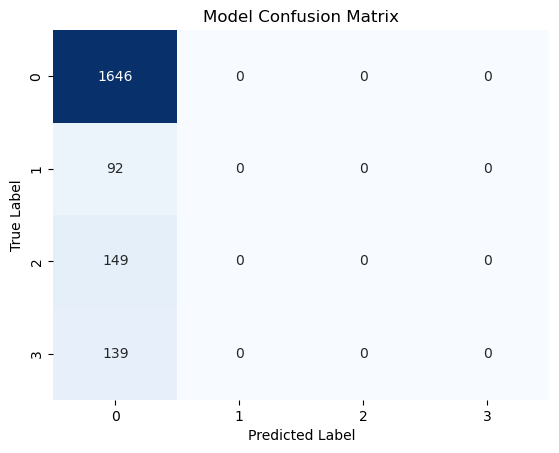

In [18]:
## Create baseline model
# Baseline model always predicts Room_Occupancy_Count == 0
baseline_train_pred = np.zeros(y_train.shape)
baseline_val_pred = np.zeros(y_val.shape)
baseline_test_pred = np.zeros(y_test.shape)

## Evaluate baseline model against train, validation, and test data set
# Evaluate model by calculating Macro, Micro, and Weighted F1-scores
# Calculate F1-scores
print('Training Results:')
calculate_f1_scores(y_train, baseline_train_pred)

print('Validation Results:')
calculate_f1_scores(y_val, baseline_val_pred)

print('Test Results:')
calculate_f1_scores(y_test, baseline_test_pred)

# Create confusion matrix for actual and baseline predictions of y_test
conf_mat_baseline = sklearn.metrics.confusion_matrix(y_test, baseline_test_pred)
conf_mat_baseline = sns.heatmap(conf_mat_baseline, annot=True, fmt='d', cbar=False, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Model Confusion Matrix')
plt.show()


## Decision Trees

### Decision Tree (determine importance of all features with default values)

Training Results:
F1-Scores
---------
Macro average:    1.0000
Micro average:    1.0000
Weighted average: 1.0000

Validation Results:
F1-Scores
---------
Macro average:    0.7114
Micro average:    0.9245
Weighted average: 0.9221



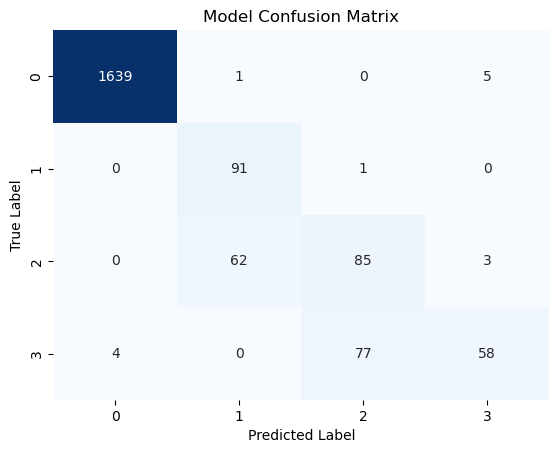

Number of features used in decision tree: 10
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.469596
5,S2_Light,0.243592
6,S3_Light,0.114900
13,S5_CO2_Slope,0.114366
11,S4_Sound,0.021496
9,S2_Sound,0.019850
3,S4_Temp,0.009185
10,S3_Sound,0.003686
7,S4_Light,0.002346
8,S1_Sound,0.000984


In [19]:
# Instantiate tree classifier
# Use gini impurity as an intermediate measure between entropy and classification error and minimize probability of misclassification
dt_clf = DecisionTreeClassifier(criterion='gini', random_state=888)

# Fit the model to X_train and y_train
dt_clf = dt_clf.fit(X_train, y_train)

# Predict the training data and probabilities
y_train_pred = dt_clf.predict(X_train)
y_train_pred_prob = dt_clf.predict_proba(X_train)

# Predict the validation data and the probabilities
y_val_pred = dt_clf.predict(X_val)
y_val_pred_prob = dt_clf.predict_proba(X_val)

# Calculate F1-scores
print('Training Results:')
calculate_f1_scores(y_train, y_train_pred)

print('Validation Results:')
calculate_f1_scores(y_val, y_val_pred)


# Create and visualize confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix")
plt.show()

# Identify and display the features selected by the decision tree model and their importance
df_dt_feature_importance = pd.DataFrame()
df_dt_feature_importance['Feature'] = features
df_dt_feature_importance['Feature Importance'] = dt_clf.feature_importances_
df_dt_feature_importance = df_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_dt_feature_importance = df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in decision tree:', len(df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_dt_feature_importance)


### Decision Tree (tune criterion and max_depth hyper parameters)

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = gini
max_depth = 1
Training Results:
F1-Scores
---------
Macro average:    0.4057
Micro average:    0.7311
Weighted average: 0.6321

Validation Results:
F1-Scores
---------
Macro average:    0.3543
Micro average:    0.8569
Weighted average: 0.8196



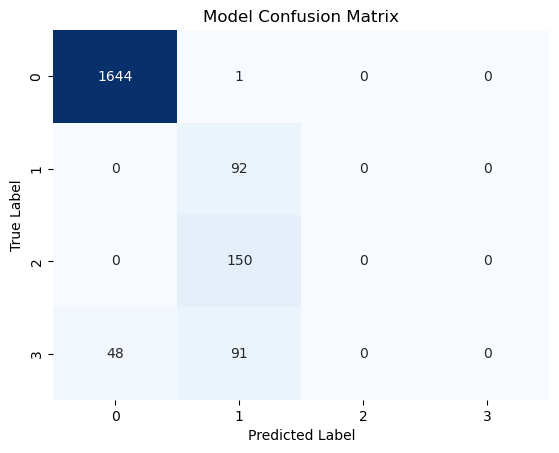

Number of features used in decision tree: 1
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,1.0


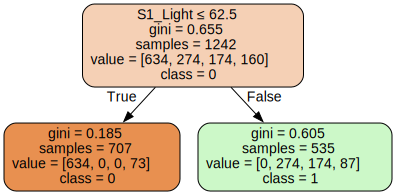

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = gini
max_depth = 2
Training Results:
F1-Scores
---------
Macro average:    0.8248
Micro average:    0.9082
Weighted average: 0.8999

Validation Results:
F1-Scores
---------
Macro average:    0.6580
Micro average:    0.9107
Weighted average: 0.9060



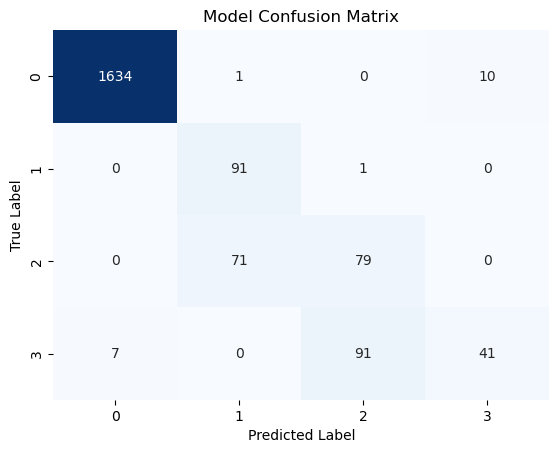

Number of features used in decision tree: 3
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.551946
5,S2_Light,0.304744
13,S5_CO2_Slope,0.143310


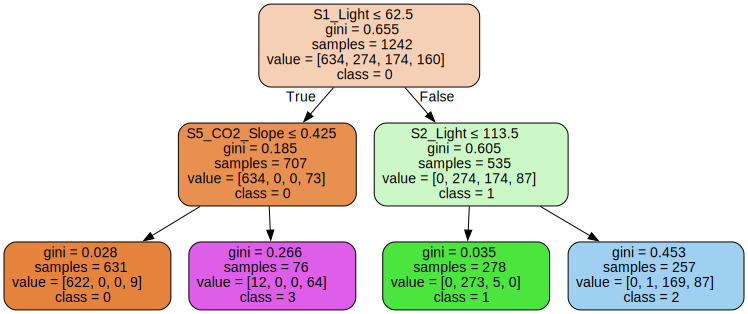

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = gini
max_depth = 3
Training Results:
F1-Scores
---------
Macro average:    0.9721
Micro average:    0.9823
Weighted average: 0.9825

Validation Results:
F1-Scores
---------
Macro average:    0.8259
Micro average:    0.9561
Weighted average: 0.9538



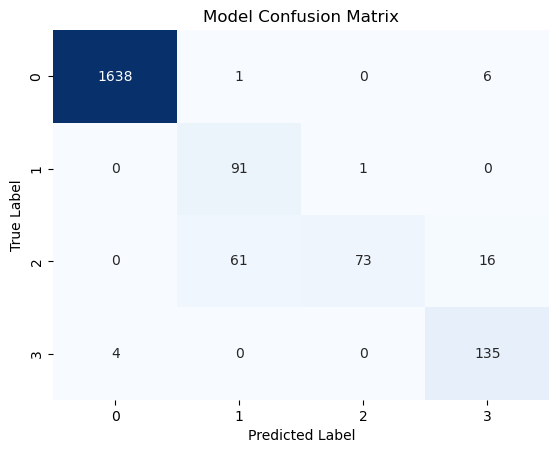

Number of features used in decision tree: 6
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.713571
13,S5_CO2_Slope,0.119369
6,S3_Light,0.117872
3,S4_Temp,0.025949
11,S4_Sound,0.012608
9,S2_Sound,0.010631


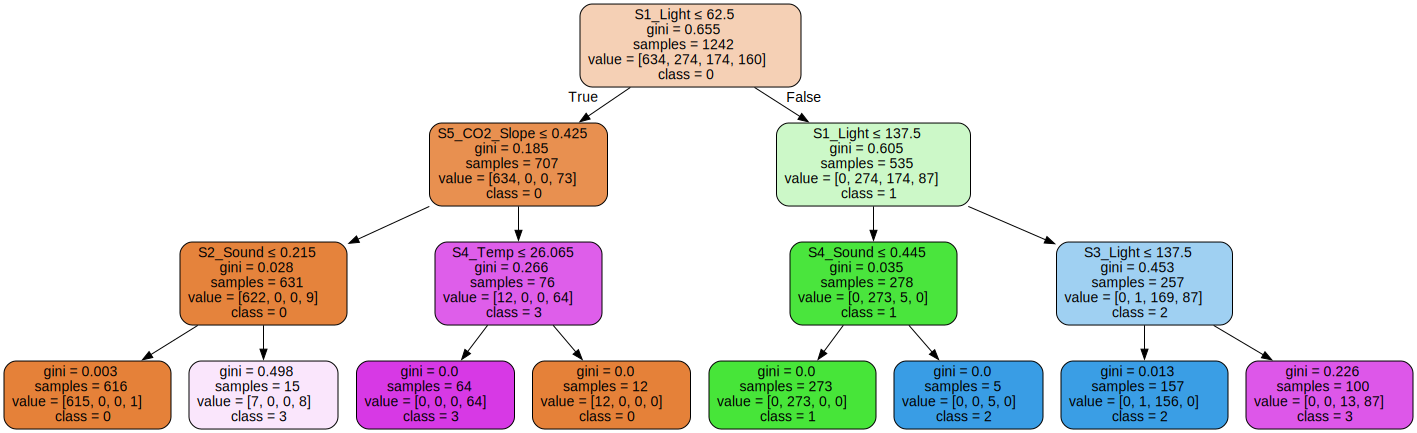

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = gini
max_depth = 4
Training Results:
F1-Scores
---------
Macro average:    0.9794
Micro average:    0.9887
Weighted average: 0.9887

Validation Results:
F1-Scores
---------
Macro average:    0.8267
Micro average:    0.9566
Weighted average: 0.9543



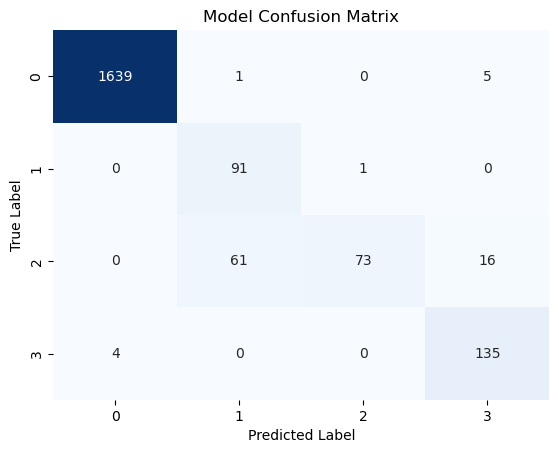

Number of features used in decision tree: 8
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.482020
5,S2_Light,0.249866
13,S5_CO2_Slope,0.117392
6,S3_Light,0.115919
11,S4_Sound,0.012400
9,S2_Sound,0.010455
3,S4_Temp,0.009428
10,S3_Sound,0.002521


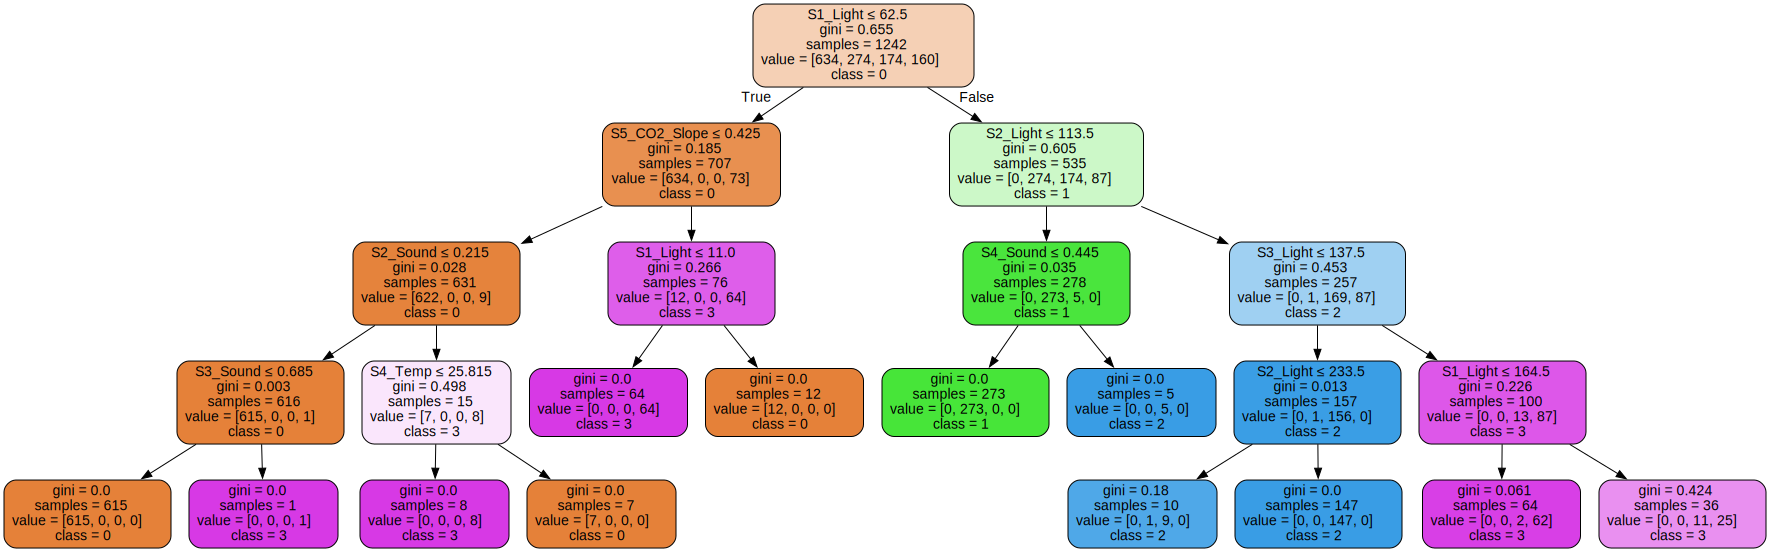

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = gini
max_depth = 5
Training Results:
F1-Scores
---------
Macro average:    0.9898
Micro average:    0.9944
Weighted average: 0.9944

Validation Results:
F1-Scores
---------
Macro average:    0.7093
Micro average:    0.9240
Weighted average: 0.9215



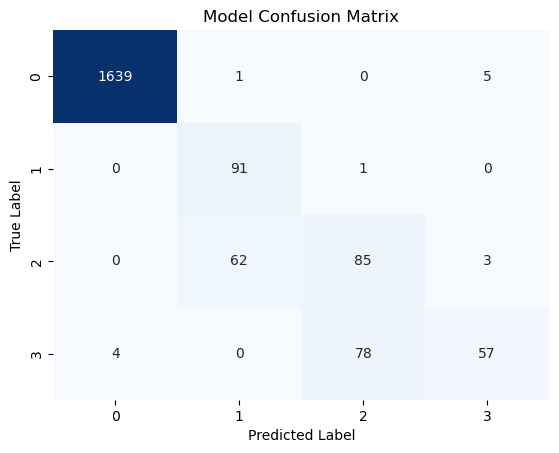

Number of features used in decision tree: 10
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.475795
5,S2_Light,0.246639
13,S5_CO2_Slope,0.115876
6,S3_Light,0.114422
11,S4_Sound,0.021780
9,S2_Sound,0.010320
3,S4_Temp,0.009306
10,S3_Sound,0.002489
7,S4_Light,0.002376
8,S1_Sound,0.000997


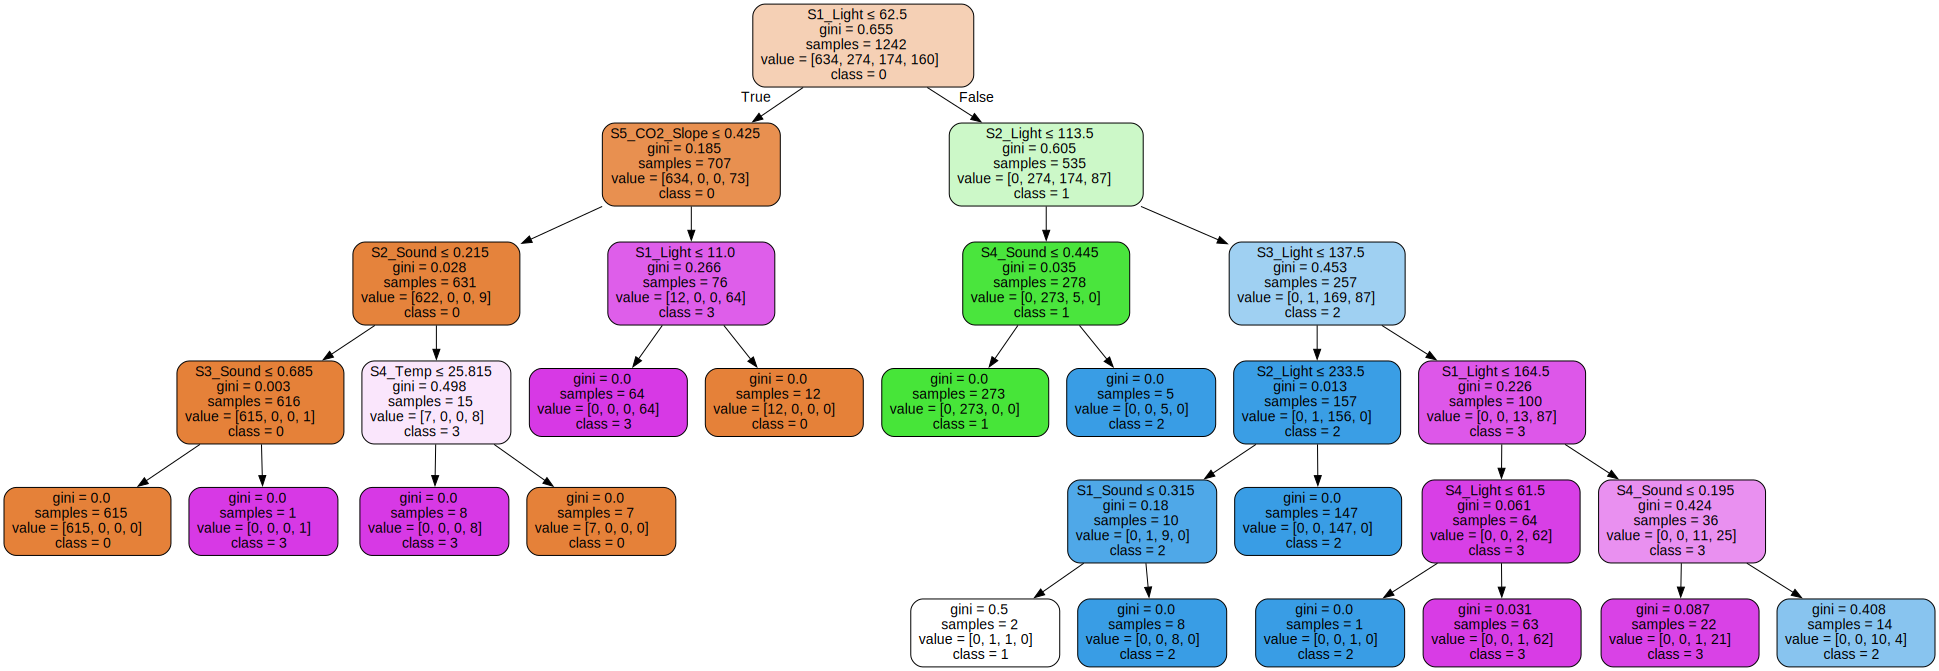

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = gini
max_depth = 6
Training Results:
F1-Scores
---------
Macro average:    0.9955
Micro average:    0.9976
Weighted average: 0.9976

Validation Results:
F1-Scores
---------
Macro average:    0.7093
Micro average:    0.9240
Weighted average: 0.9215



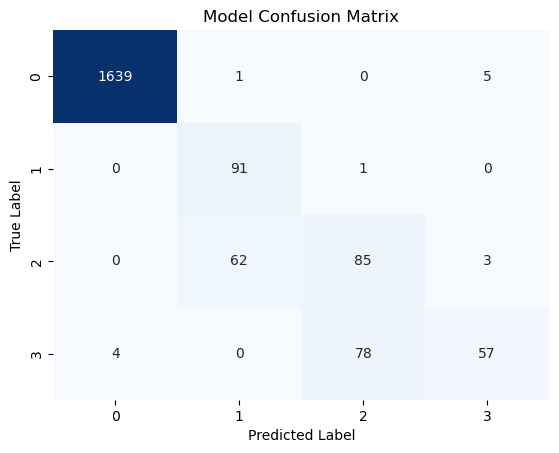

Number of features used in decision tree: 11
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.472580
5,S2_Light,0.245140
13,S5_CO2_Slope,0.115093
6,S3_Light,0.113649
11,S4_Sound,0.012157
9,S2_Sound,0.010250
12,S5_CO2,0.009476
3,S4_Temp,0.009243
8,S1_Sound,0.006342
10,S3_Sound,0.003710


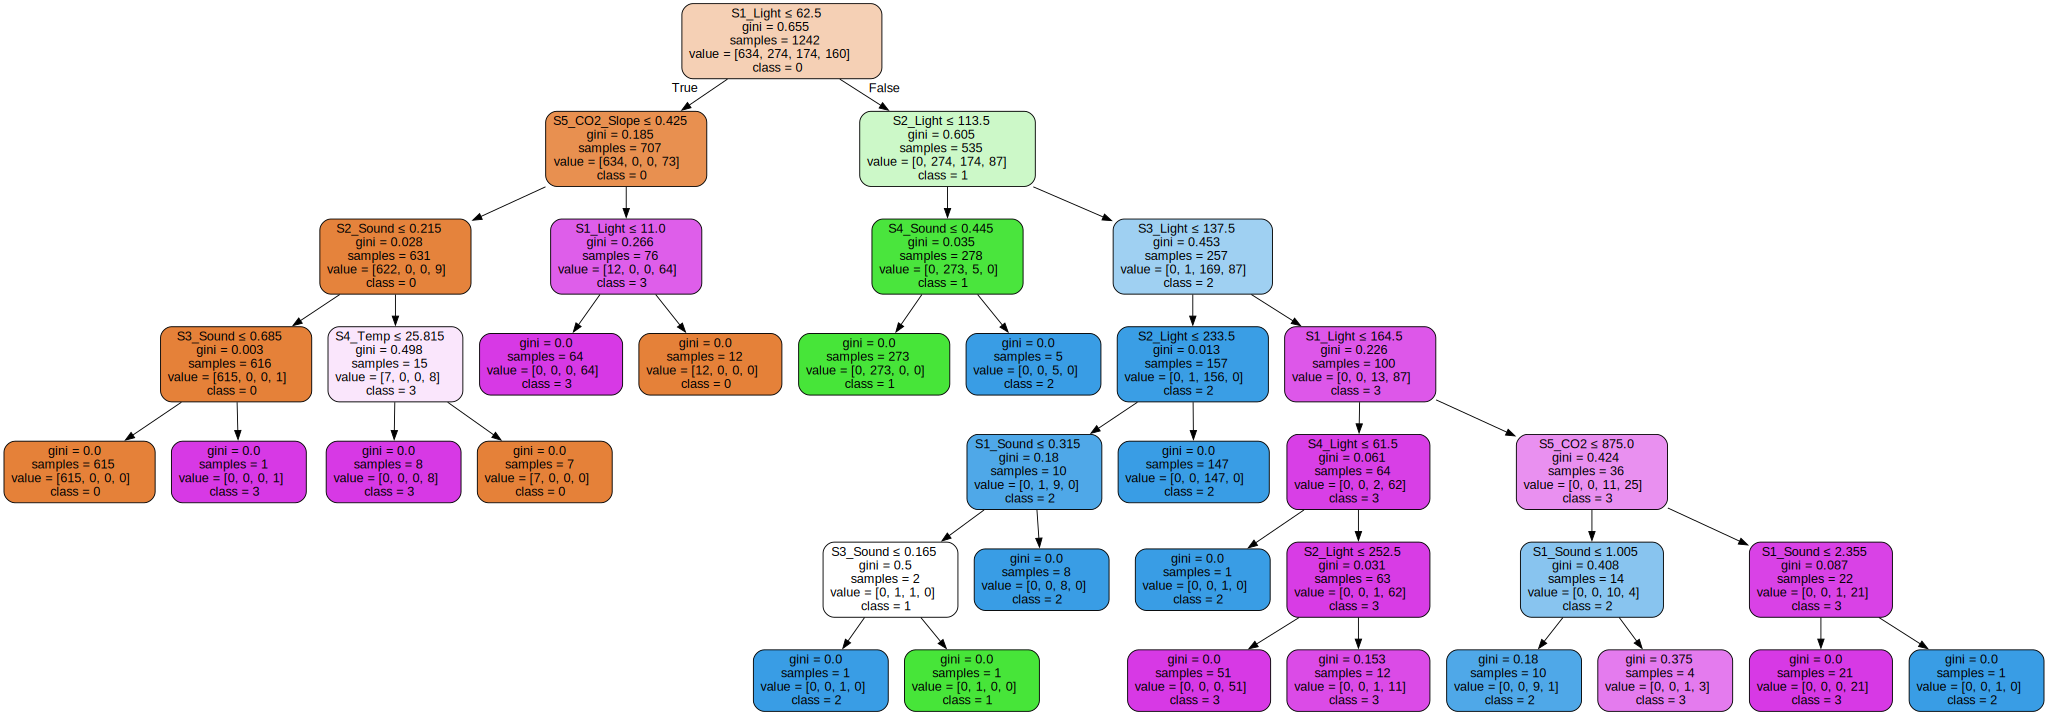

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = gini
max_depth = 7
Training Results:
F1-Scores
---------
Macro average:    1.0000
Micro average:    1.0000
Weighted average: 1.0000

Validation Results:
F1-Scores
---------
Macro average:    0.7114
Micro average:    0.9245
Weighted average: 0.9221



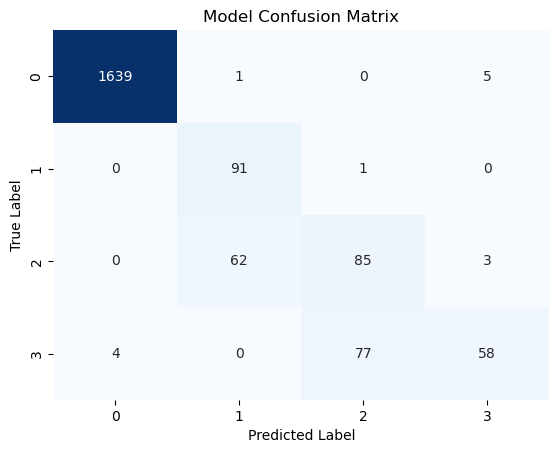

Number of features used in decision tree: 10
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.469596
5,S2_Light,0.243592
6,S3_Light,0.114900
13,S5_CO2_Slope,0.114366
11,S4_Sound,0.021496
9,S2_Sound,0.019850
3,S4_Temp,0.009185
10,S3_Sound,0.003686
7,S4_Light,0.002346
8,S1_Sound,0.000984


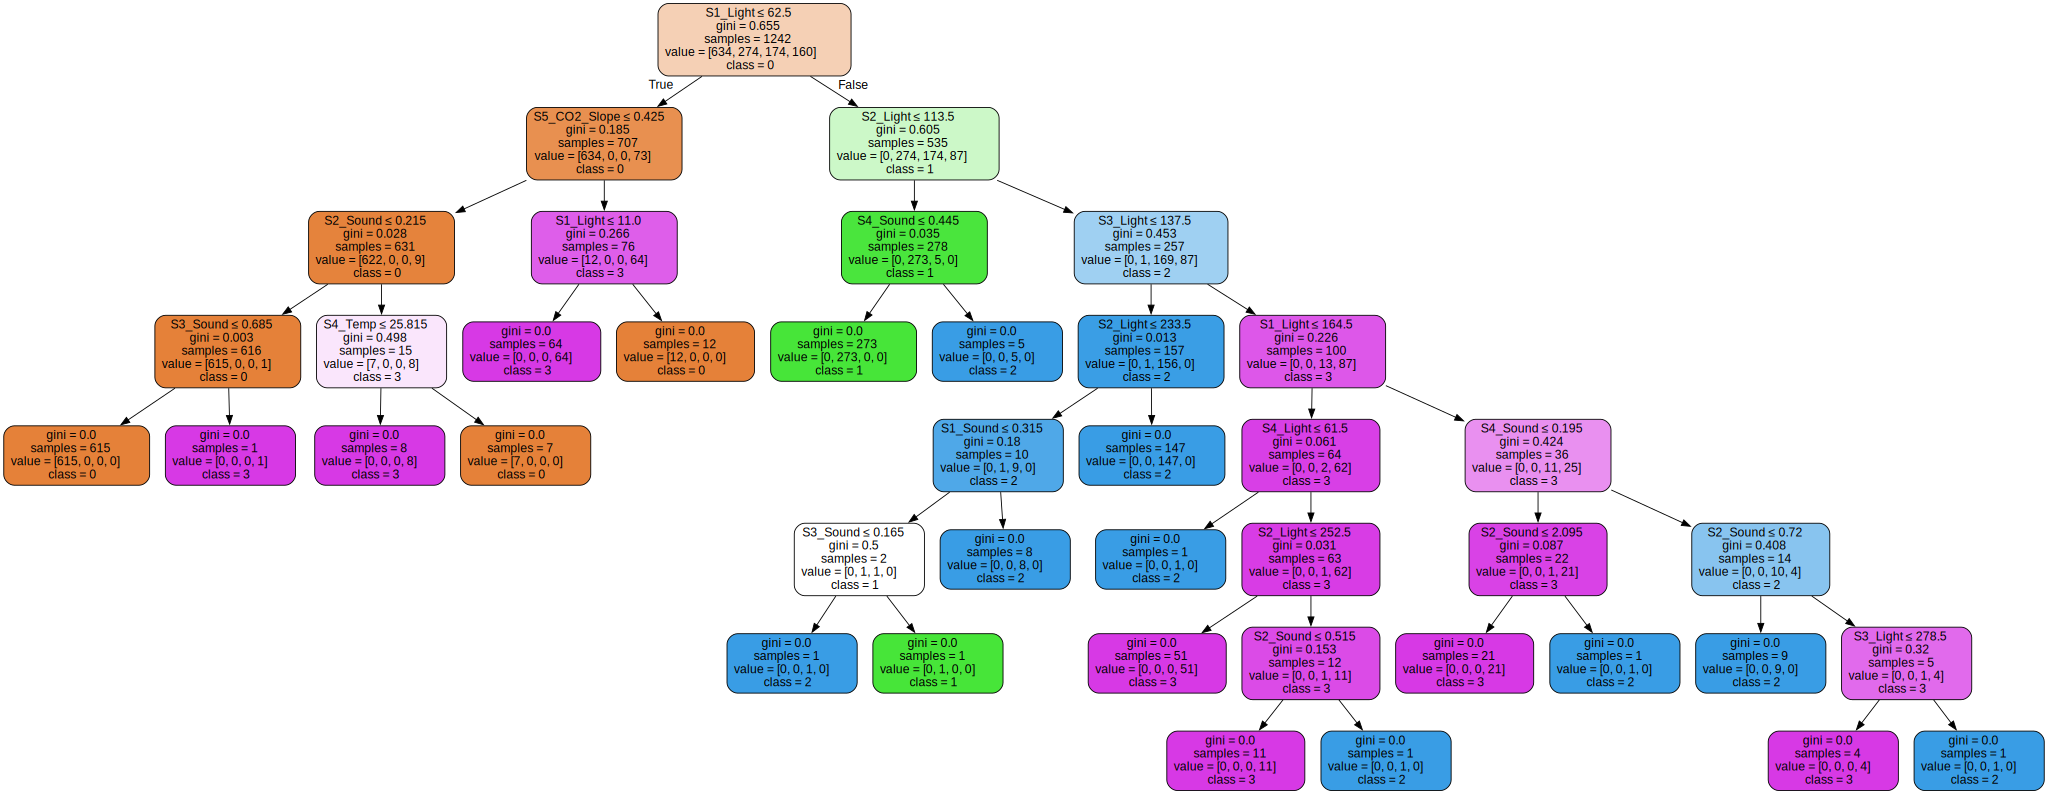

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = gini
max_depth = 8
Training Results:
F1-Scores
---------
Macro average:    1.0000
Micro average:    1.0000
Weighted average: 1.0000

Validation Results:
F1-Scores
---------
Macro average:    0.7114
Micro average:    0.9245
Weighted average: 0.9221



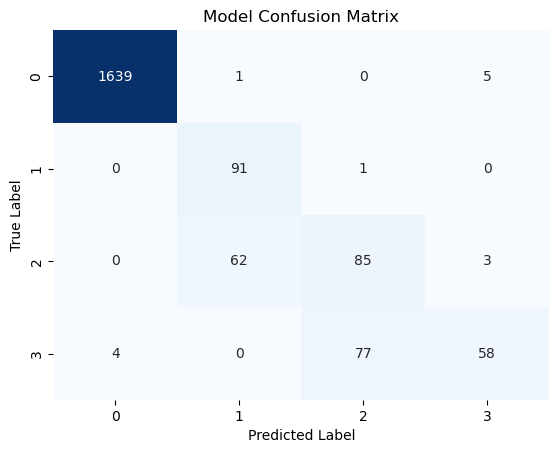

Number of features used in decision tree: 10
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.469596
5,S2_Light,0.243592
6,S3_Light,0.114900
13,S5_CO2_Slope,0.114366
11,S4_Sound,0.021496
9,S2_Sound,0.019850
3,S4_Temp,0.009185
10,S3_Sound,0.003686
7,S4_Light,0.002346
8,S1_Sound,0.000984


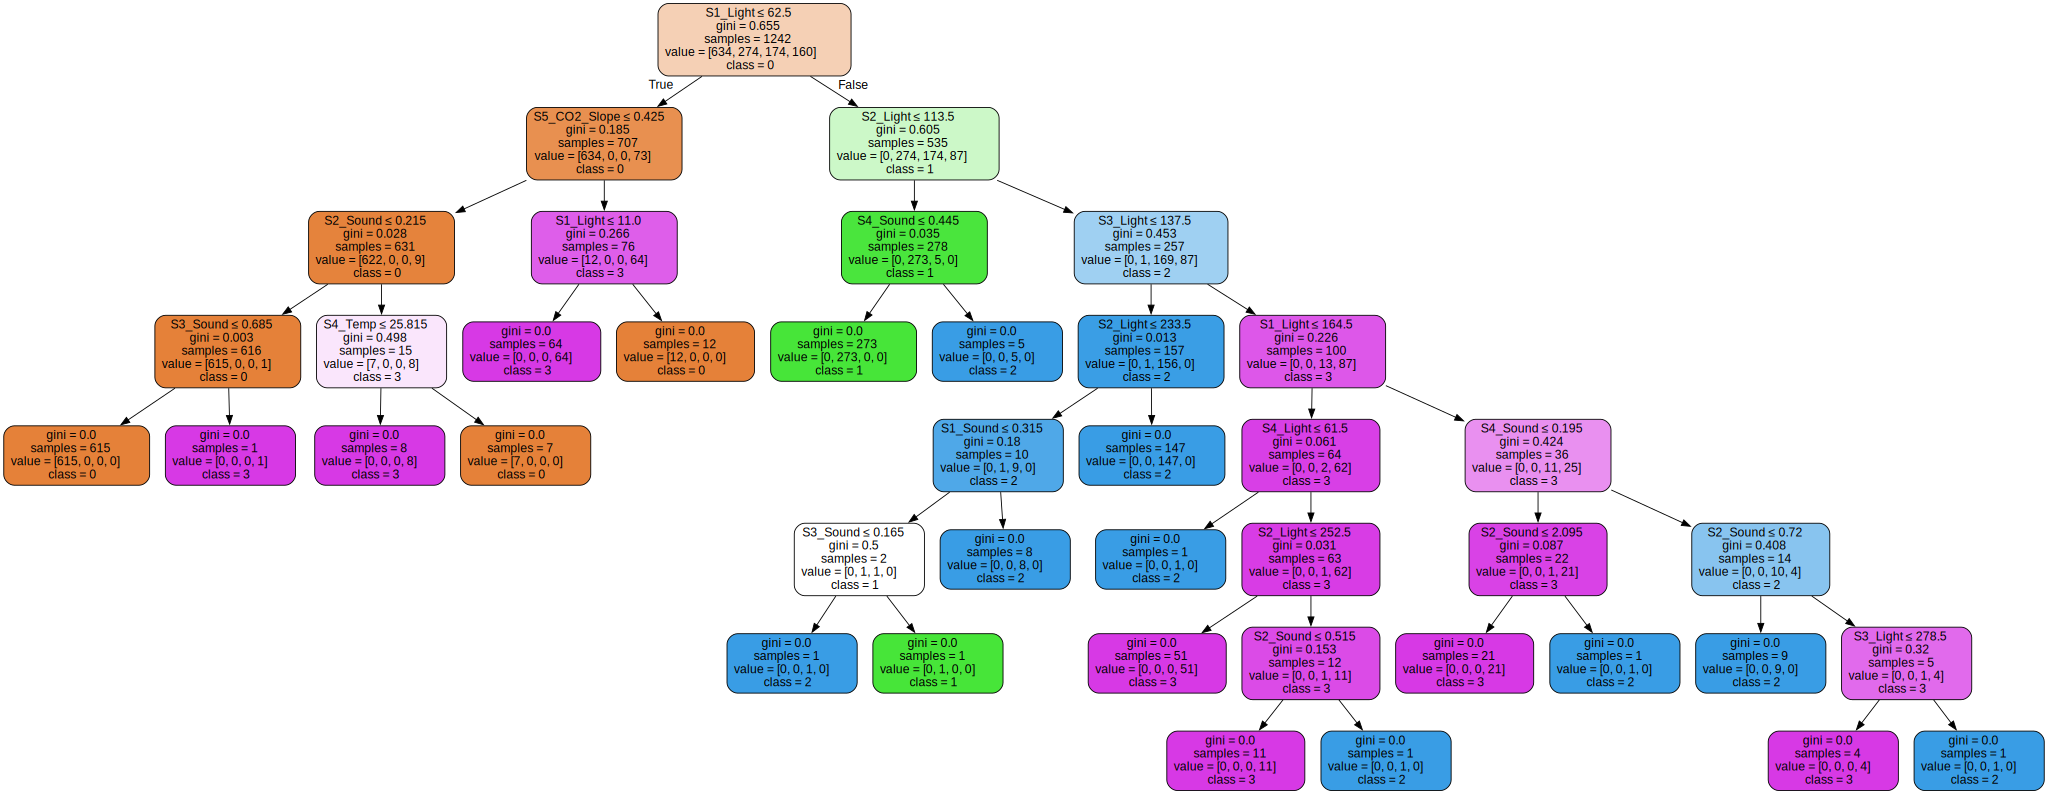

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = entropy
max_depth = 1
Training Results:
F1-Scores
---------
Macro average:    0.4057
Micro average:    0.7311
Weighted average: 0.6321

Validation Results:
F1-Scores
---------
Macro average:    0.3543
Micro average:    0.8569
Weighted average: 0.8196



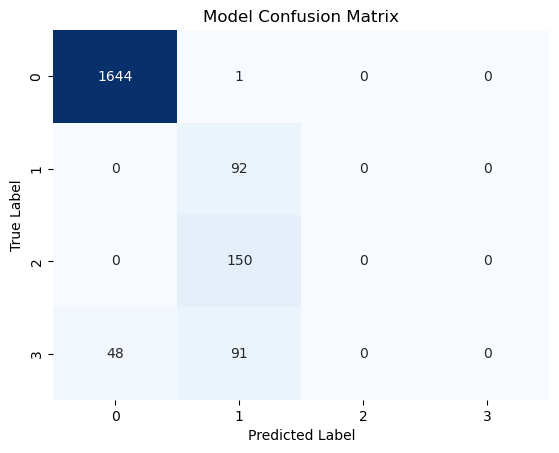

Number of features used in decision tree: 1
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,1.0


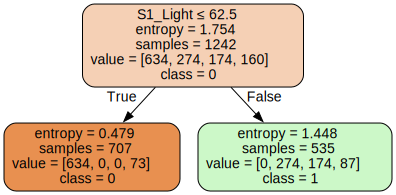

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = entropy
max_depth = 2
Training Results:
F1-Scores
---------
Macro average:    0.8241
Micro average:    0.9026
Weighted average: 0.8974

Validation Results:
F1-Scores
---------
Macro average:    0.6589
Micro average:    0.9057
Weighted average: 0.9039



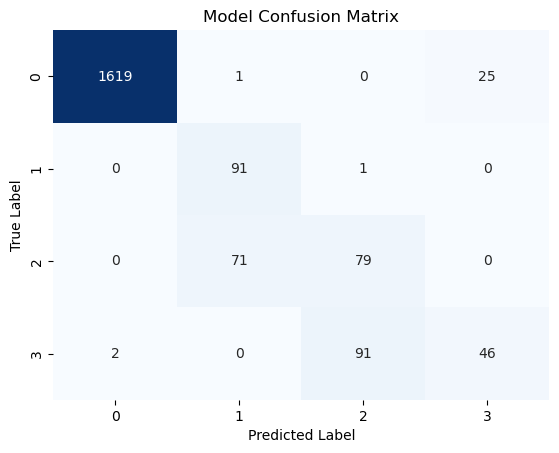

Number of features used in decision tree: 3
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.596935
5,S2_Light,0.275686
13,S5_CO2_Slope,0.127379


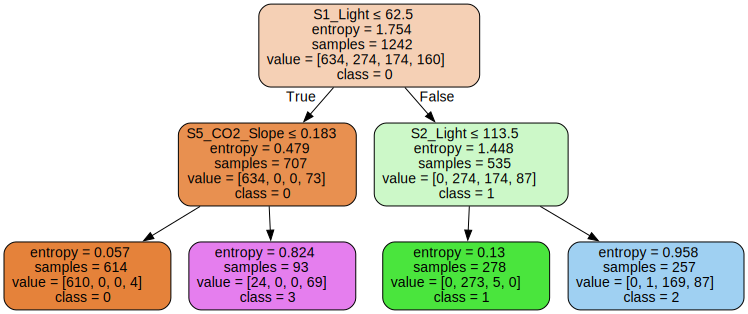

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = entropy
max_depth = 3
Training Results:
F1-Scores
---------
Macro average:    0.9754
Micro average:    0.9855
Weighted average: 0.9855

Validation Results:
F1-Scores
---------
Macro average:    0.8237
Micro average:    0.9546
Weighted average: 0.9525



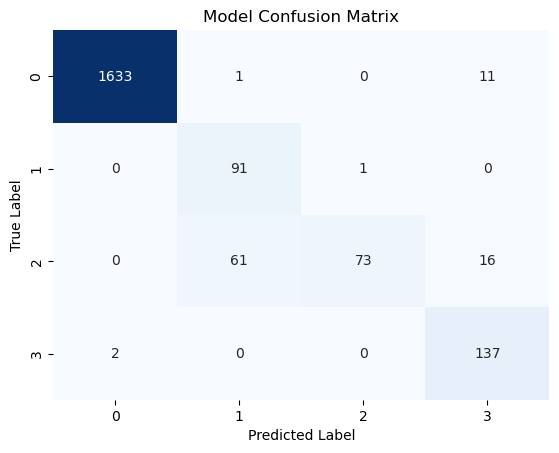

Number of features used in decision tree: 6
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.740146
13,S5_CO2_Slope,0.108041
6,S3_Light,0.086322
3,S4_Temp,0.036401
11,S4_Sound,0.017168
9,S2_Sound,0.011921


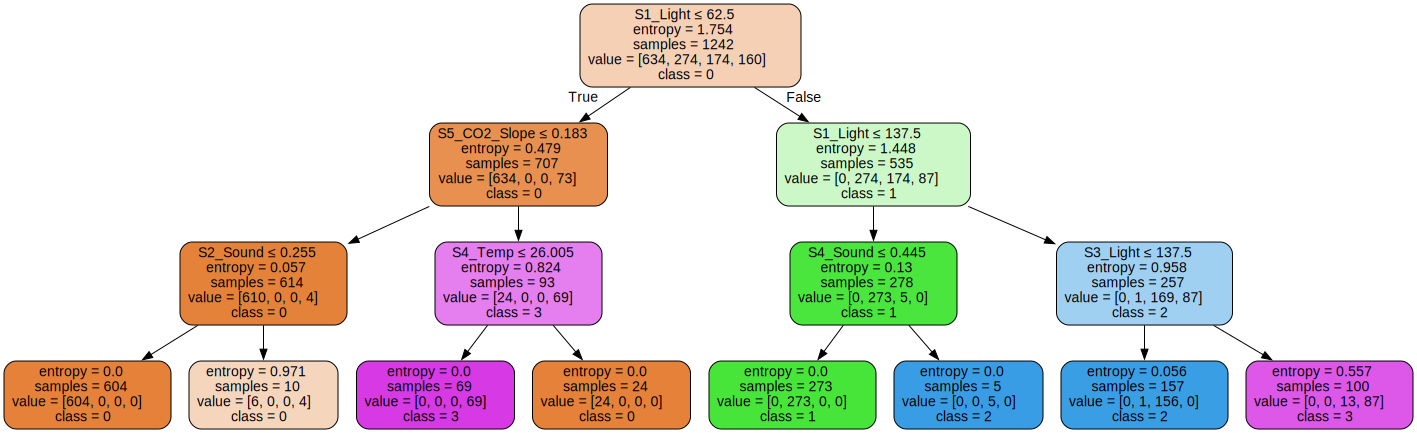

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = entropy
max_depth = 4
Training Results:
F1-Scores
---------
Macro average:    0.9794
Micro average:    0.9887
Weighted average: 0.9887

Validation Results:
F1-Scores
---------
Macro average:    0.8237
Micro average:    0.9546
Weighted average: 0.9525



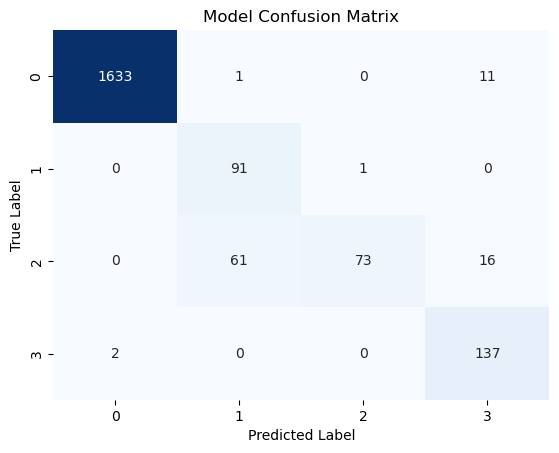

Number of features used in decision tree: 7
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.499924
5,S2_Light,0.232779
13,S5_CO2_Slope,0.112845
6,S3_Light,0.085233
3,S4_Temp,0.040497
11,S4_Sound,0.016951
9,S2_Sound,0.011771


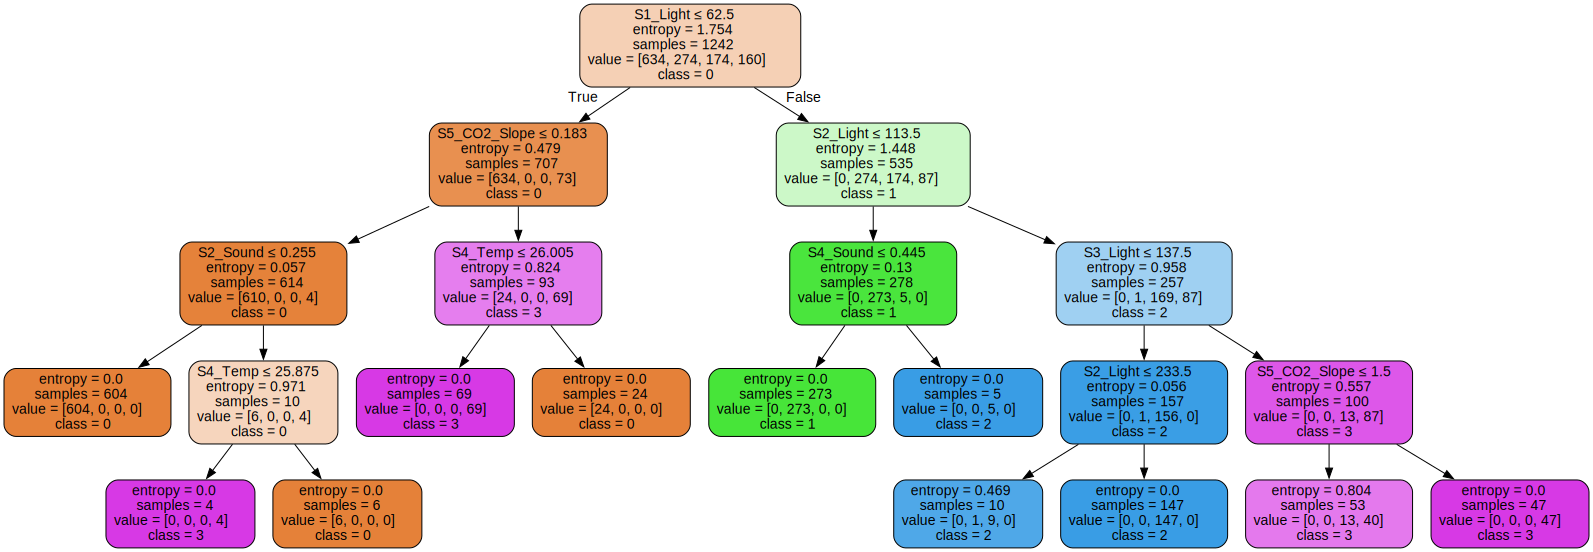

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = entropy
max_depth = 5
Training Results:
F1-Scores
---------
Macro average:    0.9793
Micro average:    0.9887
Weighted average: 0.9887

Validation Results:
F1-Scores
---------
Macro average:    0.8237
Micro average:    0.9546
Weighted average: 0.9525



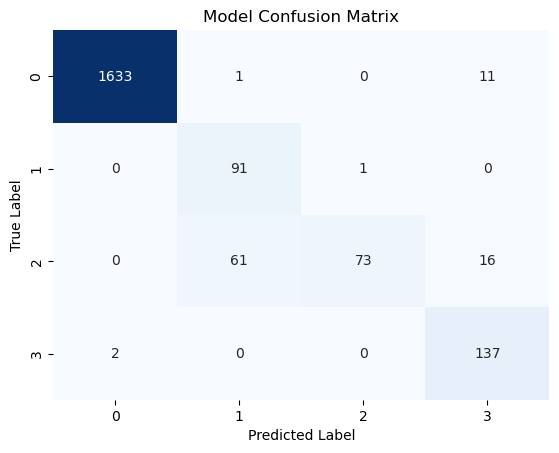

Number of features used in decision tree: 7
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.497208
5,S2_Light,0.231514
13,S5_CO2_Slope,0.112232
6,S3_Light,0.084770
3,S4_Temp,0.040277
11,S4_Sound,0.018114
9,S2_Sound,0.015884


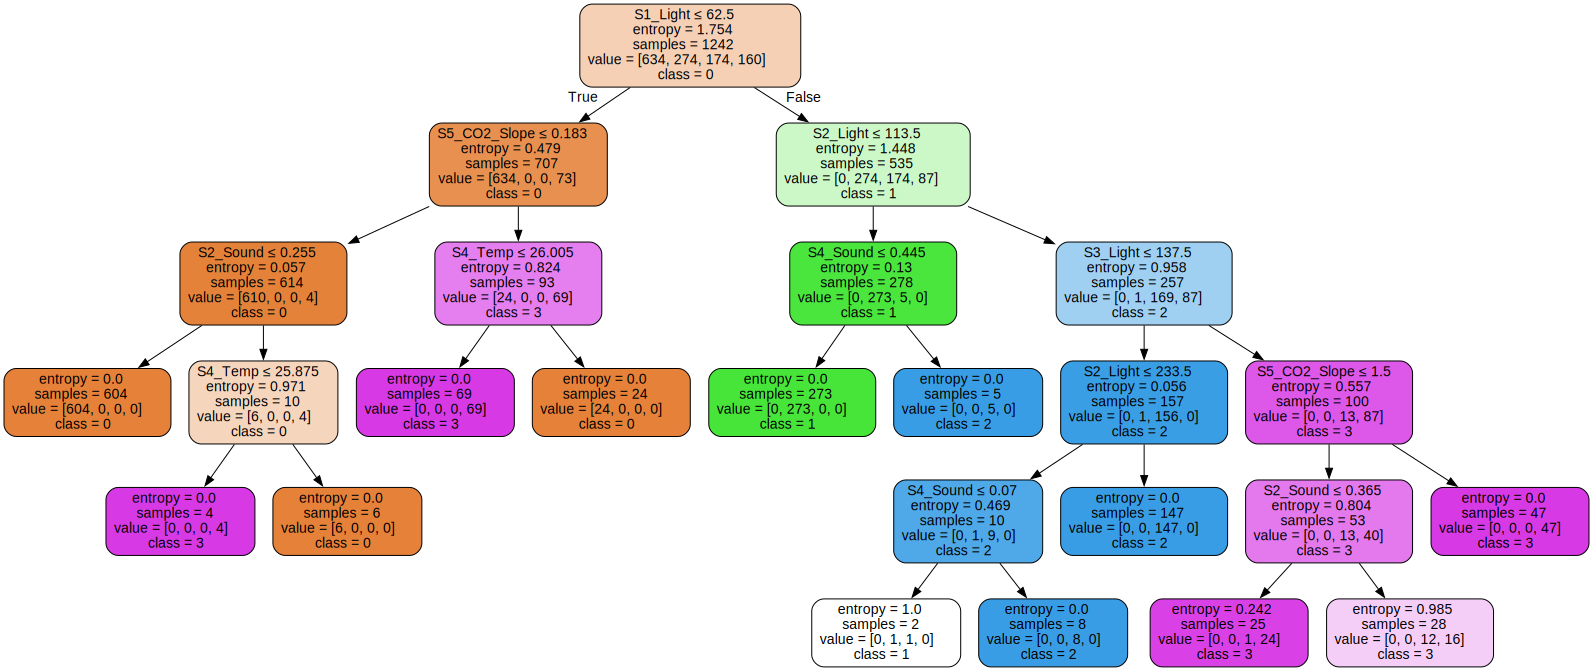

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = entropy
max_depth = 6
Training Results:
F1-Scores
---------
Macro average:    0.9910
Micro average:    0.9952
Weighted average: 0.9952

Validation Results:
F1-Scores
---------
Macro average:    0.8221
Micro average:    0.9531
Weighted average: 0.9521



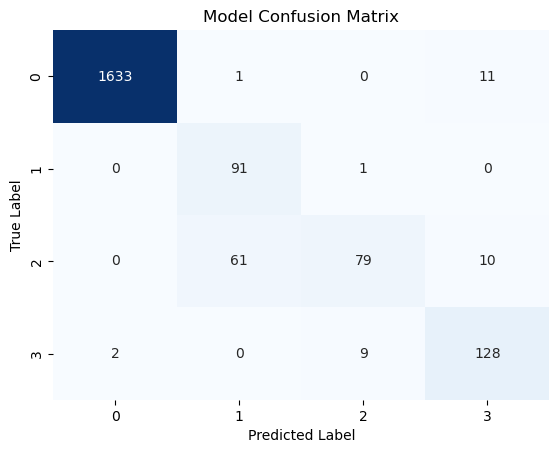

Number of features used in decision tree: 8
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.492813
5,S2_Light,0.234581
13,S5_CO2_Slope,0.111240
6,S3_Light,0.086822
3,S4_Temp,0.039921
11,S4_Sound,0.017954
9,S2_Sound,0.015744
8,S1_Sound,0.000925


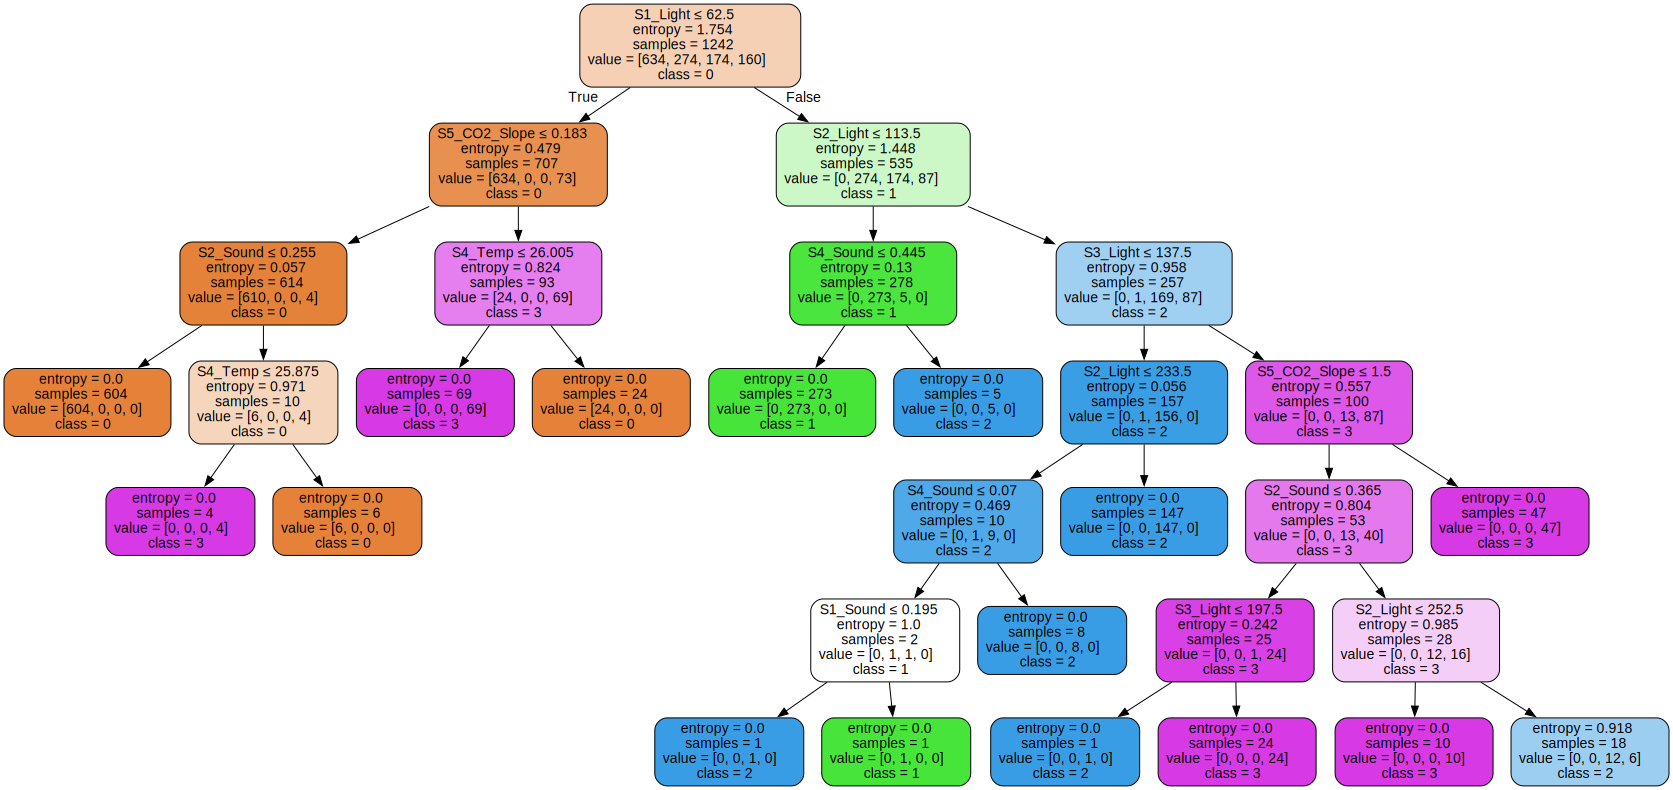

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = entropy
max_depth = 7
Training Results:
F1-Scores
---------
Macro average:    0.9955
Micro average:    0.9976
Weighted average: 0.9976

Validation Results:
F1-Scores
---------
Macro average:    0.8221
Micro average:    0.9531
Weighted average: 0.9521



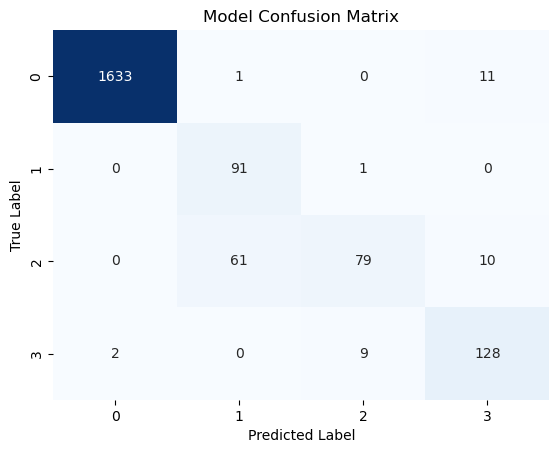

Number of features used in decision tree: 8
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.491517
5,S2_Light,0.233965
13,S5_CO2_Slope,0.110948
6,S3_Light,0.086594
3,S4_Temp,0.039816
11,S4_Sound,0.020536
9,S2_Sound,0.015702
8,S1_Sound,0.000922


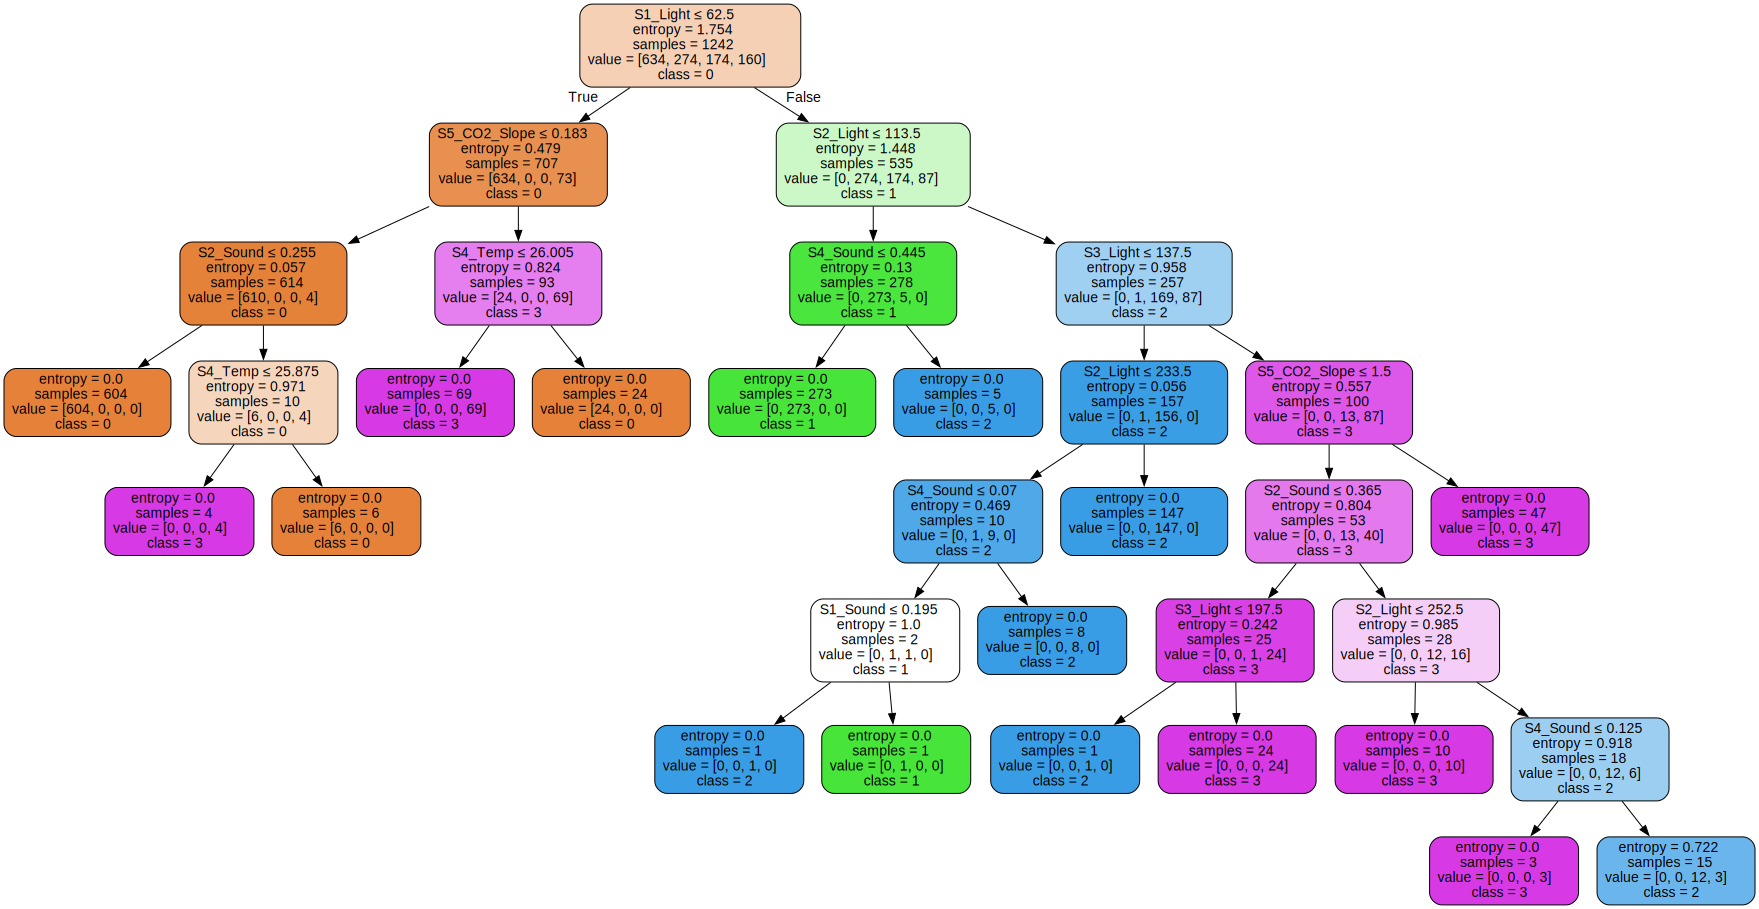

-------------------------------------------------------------------------------------------------------------------------
Hyperparameters
criterion = entropy
max_depth = 8
Training Results:
F1-Scores
---------
Macro average:    0.9970
Micro average:    0.9984
Weighted average: 0.9984

Validation Results:
F1-Scores
---------
Macro average:    0.8238
Micro average:    0.9536
Weighted average: 0.9526



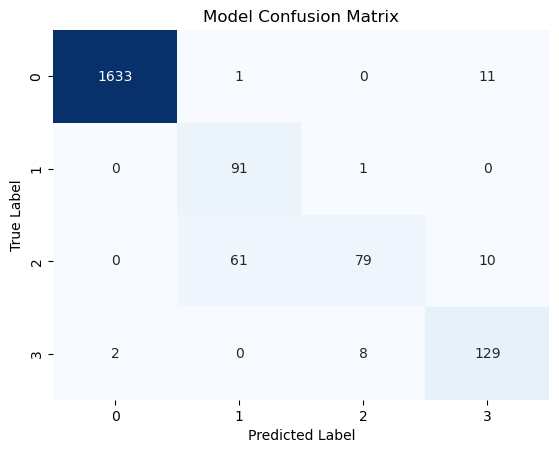

Number of features used in decision tree: 8
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.490167
5,S2_Light,0.233322
13,S5_CO2_Slope,0.110643
6,S3_Light,0.086356
3,S4_Temp,0.039707
11,S4_Sound,0.020480
9,S2_Sound,0.018407
8,S1_Sound,0.000920


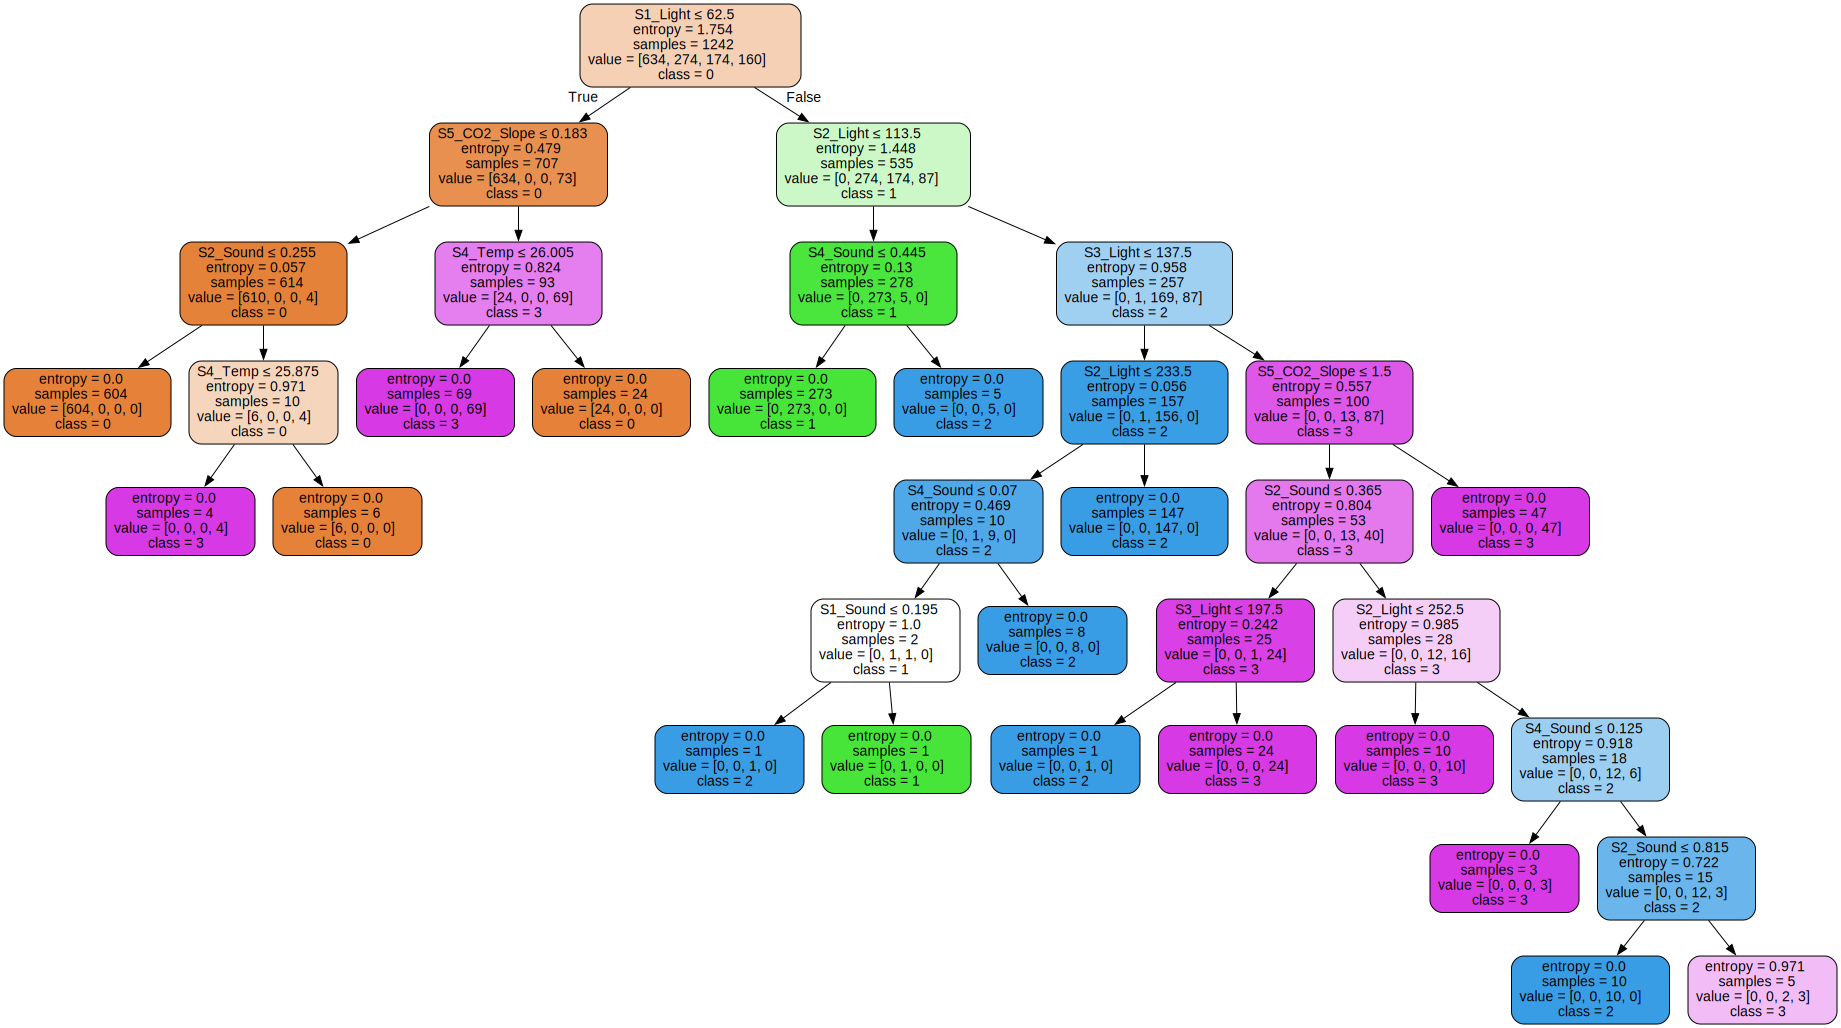

In [20]:
# Create dataframe to store evaluation metrics of each tree iteration
df_tree_f1s = pd.DataFrame(columns=['Criterion','Tree Depth', 'Val. Macro F1', 'Val. Micro F1', 'Val. Weighted F1'])

## Loop through combos of criterion and max_depth and record macro f1 score on training and validation data to determine optimal values of hyper parameters
# Create lists for each hyper parameter options
max_depths = [1, 2, 3, 4, 5, 6, 7, 8]
criterion = ['gini', 'entropy']

# create combinations of all criterion and max_depths
criterion_depth_combos = list(itertools.product(criterion, max_depths))

# Instantiate lists to hold results
train_results = []
val_results = []

# Loop through combos, print iteration details, capture f1 scores, add results to lists and dataframe for future analysis
for combo in criterion_depth_combos:
    criterion = combo[0]
    depth = combo[1]
    print('-------------------------------------------------------------------------------------------------------------------------')
    print("==========================")
    print("Hyperparameters")
    print("criterion =", criterion)
    print("max_depth =", depth)
    print("==========================")
    macro_f1_tree_train, micro_f1_tree_train, weighted_f1_tree_train, macro_f1_tree_val, micro_f1_tree_val, weighted_f1_tree_val = get_decision_tree(criterion=criterion, max_depth=depth)
    train_results.append(macro_f1_tree_train)
    val_results.append(macro_f1_tree_val)
    df_tree_f1s = pd.concat([df_tree_f1s, pd.DataFrame([[criterion, depth, macro_f1_tree_val, micro_f1_tree_val, weighted_f1_tree_val]], columns=df_tree_f1s.columns)], ignore_index=True)

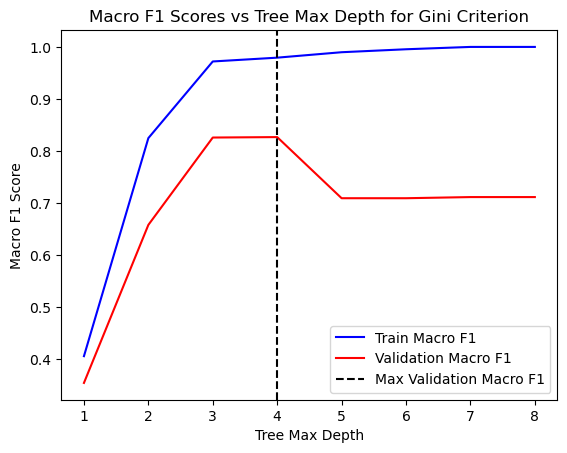

In [21]:
# Plot Macro F1 scores vs max_depth for gini criterion (equivalent of loss curve for decision tree hyperparameter tuning)
line1, = plt.plot(max_depths, train_results[0:len(max_depths)], 'b', label='Train Macro F1')
line2, = plt.plot(max_depths, val_results[0:len(max_depths)], 'r', label='Validation Macro F1')
plt.axvline(x=(val_results[0:len(max_depths)].index(max(val_results[0:len(max_depths)]))+1), color='k', label='Max Validation Macro F1', linestyle='dashed')

plt.legend()
plt.ylabel('Macro F1 Score')
plt.xlabel('Tree Max Depth')
plt.title('Macro F1 Scores vs Tree Max Depth for Gini Criterion')
plt.show()

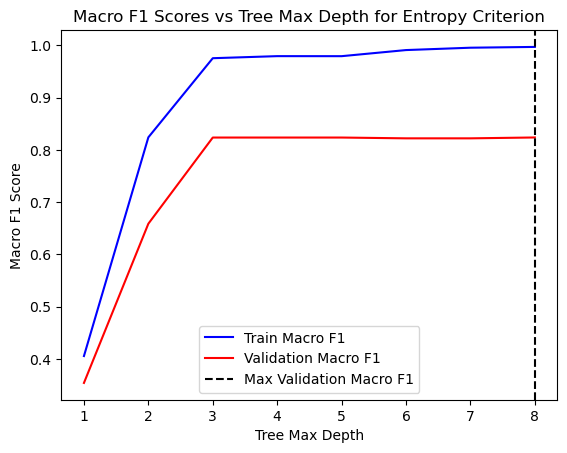

In [22]:
# Plot Macro F1 scores vs max_depth for entropy criterion (equivalent of loss curve for decision tree hyperparameter tuning)
line1, = plt.plot(max_depths, train_results[len(max_depths):], 'b', label='Train Macro F1')
line2, = plt.plot(max_depths, val_results[len(max_depths):], 'r', label='Validation Macro F1')
plt.axvline(x=(val_results[len(max_depths):].index(max(val_results[len(max_depths):]))+1), color='k', label='Max Validation Macro F1', linestyle='dashed')

plt.legend()
plt.ylabel('Macro F1 Score')
plt.xlabel('Tree Max Depth')
plt.title('Macro F1 Scores vs Tree Max Depth for Entropy Criterion')
plt.show()

### Compare Decision Tree Models with different hyper parameters

In [23]:
# Display dataframe that stores F1-scores from each iteration
display(df_tree_f1s)

# print best hyper parameters based on maximum macro f1-score
print('Hyper parameters that maximize macro f1-score in decision tree models:')
print(df_tree_f1s[df_tree_f1s['Val. Macro F1']== df_tree_f1s['Val. Macro F1'].max()].to_string(index=False))



# Output indicates criterion='gini' and max_depth=4 has the optimal F1-scores across the board == Best place to prune.

,Criterion,Tree Depth,Val. Macro F1,Val. Micro F1,Val. Weighted F1
0,gini,1,0.354310,0.856861,0.819636
1,gini,2,0.658010,0.910661,0.905959
2,gini,3,0.825865,0.956071,0.953799
3,gini,4,0.826714,0.956565,0.954259
4,gini,5,0.709255,0.923988,0.921495
5,gini,6,0.709255,0.923988,0.921495
6,gini,7,0.711445,0.924482,0.922105
7,gini,8,0.711445,0.924482,0.922105
8,entropy,1,0.354310,0.856861,0.819636
9,entropy,2,0.658865,0.905726,0.903893


Hyper parameters that maximize macro f1-score in decision tree models:
Criterion Tree Depth  Val. Macro F1  Val. Micro F1  Val. Weighted F1
     gini          4       0.826714       0.956565          0.954259


Thoughts to further tune the model above: https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use
- Combine train and validation data, retrain / run decision tree
- Try different values for min_samples_split and min_smaples_leaf
    - min_samples_leaf = min # of samples required to be at a leaf node (try 5 as an intial value, for classification with few classes min_sample_leaf=1 is often the best choice)
    - min_samples_split = min # samples required to split a node 
- Minimal cost-complexity Pruning: https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning
- Use PCA or feature selection beforehand to give tree better chance at finding discriminative features?

### Evaluate Decision Tree (train data only)

Training Results:
F1-Scores
---------
Macro average:    0.9794
Micro average:    0.9887
Weighted average: 0.9887

Validation Results:
F1-Scores
---------
Macro average:    0.8267
Micro average:    0.9566
Weighted average: 0.9543

Test Results:
F1-Scores
---------
Macro average:    0.8727
Micro average:    0.9684
Weighted average: 0.9673



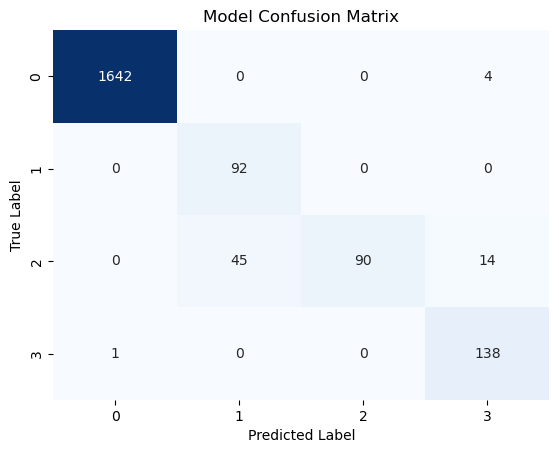

Number of features used in decision tree: 8
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.482020
5,S2_Light,0.249866
13,S5_CO2_Slope,0.117392
6,S3_Light,0.115919
11,S4_Sound,0.012400
9,S2_Sound,0.010455
3,S4_Temp,0.009428
10,S3_Sound,0.002521


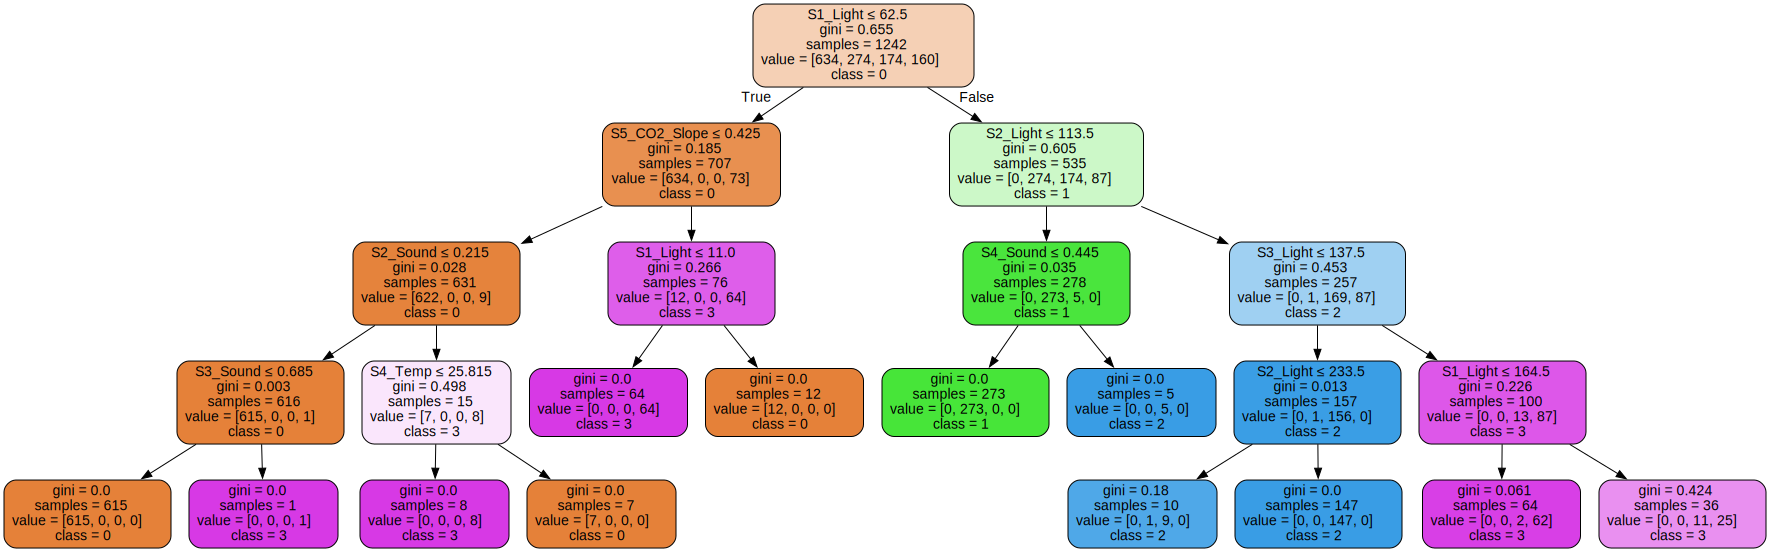

In [24]:
# Instatiate tree classifier
dt_clf = DecisionTreeClassifier(criterion='gini', random_state=888, max_depth=4)

# Fit the model to the training data set 
dt_clf = dt_clf.fit(X_train, y_train)

# Predict the train data and the probabilities
y_train_pred = dt_clf.predict(X_train)
y_train_pred_prob = dt_clf.predict_proba(X_train)

# Predict the train data and the probabilities
y_val_pred = dt_clf.predict(X_val)
y_val_pred_prob = dt_clf.predict_proba(X_val)

# Predict the test data and the probabilities
y_test_pred = dt_clf.predict(X_test)
y_test_pred_prob = dt_clf.predict_proba(X_test)

# Calculate F1-scores
print('Training Results:')
calculate_f1_scores(y_train, y_train_pred)

print('Validation Results:')
calculate_f1_scores(y_val, y_val_pred)

print('Test Results:')
calculate_f1_scores(y_test, y_test_pred)

# Create and visualize the confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix")
plt.show()

# Identify and display the features selected by the decision tree model and their importance
df_dt_feature_importance = pd.DataFrame()
df_dt_feature_importance['Feature'] = features
df_dt_feature_importance['Feature Importance'] = dt_clf.feature_importances_
df_dt_feature_importance = df_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_dt_feature_importance = df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in decision tree:', len(df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_dt_feature_importance)

# Use graphviz to visualize the decision tree
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                                feature_names=features,
                                class_names=['0','1','2','3'],
                                filled=True, rounded=True,
                                special_characters=True,
                                # leaves_parallel=True,
                                )
graph = graphviz.Source(dot_data, format='svg')
display(graph)

### Evaluate Decision Tree (combined train and validation dataset)

Combined Training / Validation Results:
F1-Scores
---------
Macro average:    0.9564
Micro average:    0.9826
Weighted average: 0.9826

Test Results:
F1-Scores
---------
Macro average:    0.9650
Micro average:    0.9901
Weighted average: 0.9901



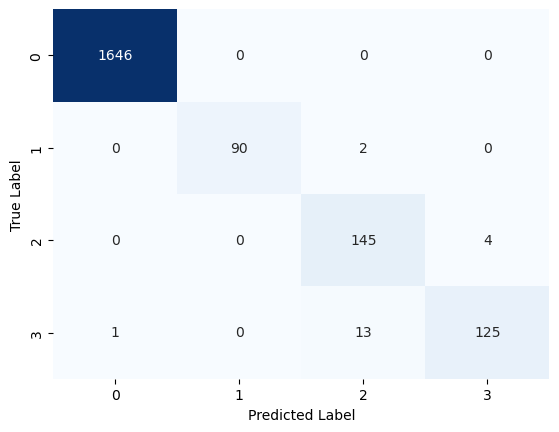

Number of features used in decision tree: 10
Features used in the model and their importance:


,Feature,Feature Importance
4,S1_Light,0.536108
6,S3_Light,0.151692
13,S5_CO2_Slope,0.109392
12,S5_CO2,0.074716
5,S2_Light,0.068156
1,S2_Temp,0.023768
0,S1_Temp,0.023278
15,S7_PIR,0.010115
8,S1_Sound,0.001434
3,S4_Temp,0.001341


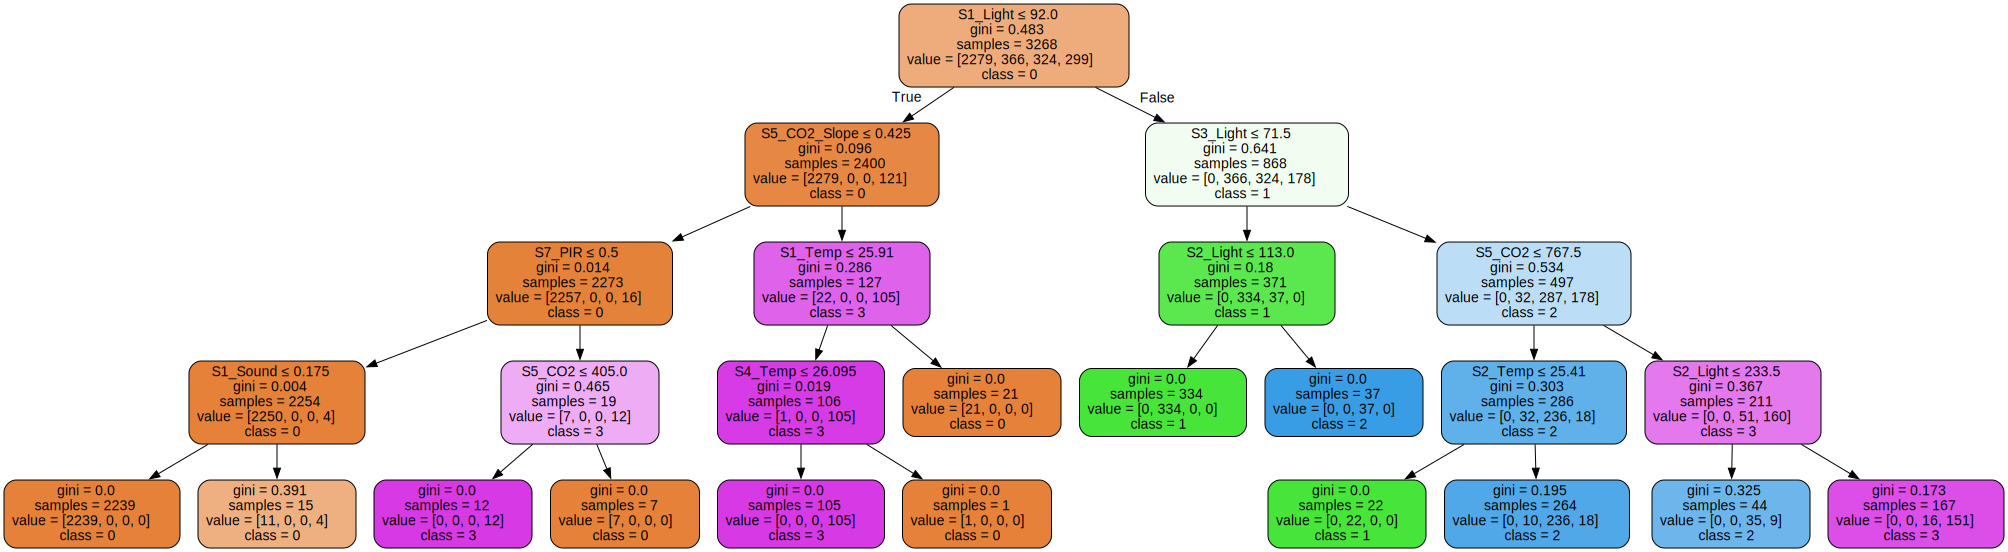

In [25]:
# Instantiate tree classifier
dt_clf = DecisionTreeClassifier(criterion='gini', random_state=888, max_depth=4)

# Fit the model to the combined train_val data set
dt_clf = dt_clf.fit(X_train_val, y_train_val)

# Predict the training data and the probabilities
y_train_val_pred = dt_clf.predict(X_train_val)
y_train_val_pred_prob = dt_clf.predict_proba(X_train_val)

# Predict the test data and the probabilities
y_test_pred = dt_clf.predict(X_test)
y_test_pred_prob = dt_clf.predict_proba(X_test)

# Calculate F1-scores
print('Combined Training / Validation Results:')
calculate_f1_scores(y_train_val, y_train_val_pred)

print('Test Results:')
calculate_f1_scores(y_test, y_test_pred)

# Create and visualize the confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_test, y_test_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Identify and display the features selected by the decision tree model and their importance
df_dt_feature_importance = pd.DataFrame()
df_dt_feature_importance['Feature'] = features
df_dt_feature_importance['Feature Importance'] = dt_clf.feature_importances_
df_dt_feature_importance = df_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_dt_feature_importance = df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in decision tree:', len(df_dt_feature_importance[df_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_dt_feature_importance)

# Use graphviz to visualize the decision tree
dot_data = tree.export_graphviz(dt_clf, out_file=None,
                                feature_names=features,
                                class_names=['0','1','2','3'],
                                filled=True, rounded=True,
                                special_characters=True,
                                # leaves_parallel=True,
                                )
graph = graphviz.Source(dot_data, format='svg')
display(graph)

## Gradient Boosted Decision Trees

### Gradient Boosted Decision Tree (determine importance of all features with default values)

In [ ]:
## Instantiate gradient boosted decision tree classifier
gboost_dt_clf = GradientBoostingClassifier(#learning_rate = 0.1,
                                           #n_estimators = 100,
                                           #max_depth = 3,
                                           random_state=888)

# Fit classifier to X_train and y_train
gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

# Predict the validation data and the probabilities
y_val_pred = gboost_dt_clf.predict(X_val)
y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

# Calculate F1-scores
macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree = calculate_f1_scores(y_val, y_val_pred)

# Plot confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix")
plt.show()

# Plot final tree
# gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]

# Display feature importance sorted by importance descending
pd.options.display.float_format = '{:20,.6f}'.format
df_gboost_dt_feature_importance = pd.DataFrame()
df_gboost_dt_feature_importance['Feature'] = features
df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in ensemble:', len(df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_gboost_dt_feature_importance)

### Gradient Boosted Decision Tree (vary max_depth between 1-8)

In [ ]:
## Instantiate gradient boosted decision tree classifier
gboost_dt_clf = GradientBoostingClassifier(#learning_rate = 0.1,
                                           #n_estimators = 100,
                                           max_depth = 1,
                                           random_state=888)

# Fit classifier to X_train and y_train
gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

# Predict the validation data and the probabilities
y_val_pred = gboost_dt_clf.predict(X_val)
y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

# Calculate F1-scores
macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree = calculate_f1_scores(y_val, y_val_pred)

# Plot confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix")
plt.show()

# Plot final tree
# gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]

# Display feature importance sorted by importance descending
pd.options.display.float_format = '{:20,.6f}'.format
df_gboost_dt_feature_importance = pd.DataFrame()
df_gboost_dt_feature_importance['Feature'] = features
df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in ensemble:', len(df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_gboost_dt_feature_importance)

In [ ]:
## Instantiate gradient boosted decision tree classifier
gboost_dt_clf = GradientBoostingClassifier(#learning_rate = 0.1,
                                           #n_estimators = 100,
                                           max_depth = 2,
                                           random_state=888)

# Fit classifier to X_train and y_train
gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

# Predict the validation data and the probabilities
y_val_pred = gboost_dt_clf.predict(X_val)
y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

# Calculate F1-scores
macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree = calculate_f1_scores(y_val, y_val_pred)

# Plot confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix")
plt.show()

# Plot final tree
# gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]

# Display feature importance sorted by importance descending
pd.options.display.float_format = '{:20,.6f}'.format
df_gboost_dt_feature_importance = pd.DataFrame()
df_gboost_dt_feature_importance['Feature'] = features
df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in ensemble:', len(df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_gboost_dt_feature_importance)

In [ ]:
## Instantiate gradient boosted decision tree classifier
gboost_dt_clf = GradientBoostingClassifier(#learning_rate = 0.1,
                                           #n_estimators = 100,
                                           max_depth = 3,
                                           random_state=888)

# Fit classifier to X_train and y_train
gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

# Predict the validation data and the probabilities
y_val_pred = gboost_dt_clf.predict(X_val)
y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

# Calculate F1-scores
macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree = calculate_f1_scores(y_val, y_val_pred)

# Plot confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix")
plt.show()

# Plot final tree
# gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]

# Display feature importance sorted by importance descending
pd.options.display.float_format = '{:20,.6f}'.format
df_gboost_dt_feature_importance = pd.DataFrame()
df_gboost_dt_feature_importance['Feature'] = features
df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in ensemble:', len(df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_gboost_dt_feature_importance)

In [ ]:
## Instantiate gradient boosted decision tree classifier
gboost_dt_clf = GradientBoostingClassifier(#learning_rate = 0.1,
                                           #n_estimators = 100,
                                           max_depth = 4,
                                           random_state=888)

# Fit classifier to X_train and y_train
gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

# Predict the validation data and the probabilities
y_val_pred = gboost_dt_clf.predict(X_val)
y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

# Calculate F1-scores
macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree = calculate_f1_scores(y_val, y_val_pred)

# Plot confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix")
plt.show()

# Plot final tree
# gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]

# Display feature importance sorted by importance descending
pd.options.display.float_format = '{:20,.6f}'.format
df_gboost_dt_feature_importance = pd.DataFrame()
df_gboost_dt_feature_importance['Feature'] = features
df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in ensemble:', len(df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_gboost_dt_feature_importance)

In [ ]:
## Instantiate gradient boosted decision tree classifier
gboost_dt_clf = GradientBoostingClassifier(#learning_rate = 0.1,
                                           #n_estimators = 100,
                                           max_depth = 5,
                                           random_state=888)

# Fit classifier to X_train and y_train
gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

# Predict the validation data and the probabilities
y_val_pred = gboost_dt_clf.predict(X_val)
y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

# Calculate F1-scores
macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree = calculate_f1_scores(y_val, y_val_pred)

# Plot confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix")
plt.show()

# Plot final tree
# gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]

# Display feature importance sorted by importance descending
pd.options.display.float_format = '{:20,.6f}'.format
df_gboost_dt_feature_importance = pd.DataFrame()
df_gboost_dt_feature_importance['Feature'] = features
df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in ensemble:', len(df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_gboost_dt_feature_importance)

In [ ]:
## Instantiate gradient boosted decision tree classifier
gboost_dt_clf = GradientBoostingClassifier(#learning_rate = 0.1,
                                           #n_estimators = 100,
                                           max_depth = 6,
                                           random_state=888)

# Fit classifier to X_train and y_train
gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

# Predict the validation data and the probabilities
y_val_pred = gboost_dt_clf.predict(X_val)
y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

# Calculate F1-scores
macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree = calculate_f1_scores(y_val, y_val_pred)

# Plot confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix")
plt.show()

# Plot final tree
# gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]

# Display feature importance sorted by importance descending
pd.options.display.float_format = '{:20,.6f}'.format
df_gboost_dt_feature_importance = pd.DataFrame()
df_gboost_dt_feature_importance['Feature'] = features
df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in ensemble:', len(df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_gboost_dt_feature_importance)

In [ ]:
## Instantiate gradient boosted decision tree classifier
gboost_dt_clf = GradientBoostingClassifier(#learning_rate = 0.1,
                                           #n_estimators = 100,
                                           max_depth = 7,
                                           random_state=888)

# Fit classifier to X_train and y_train
gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

# Predict the validation data and the probabilities
y_val_pred = gboost_dt_clf.predict(X_val)
y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

# Calculate F1-scores
macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree = calculate_f1_scores(y_val, y_val_pred)

# Plot confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix")
plt.show()

# Plot final tree
# gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]

# Display feature importance sorted by importance descending
pd.options.display.float_format = '{:20,.6f}'.format
df_gboost_dt_feature_importance = pd.DataFrame()
df_gboost_dt_feature_importance['Feature'] = features
df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in ensemble:', len(df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_gboost_dt_feature_importance)

In [ ]:
## Instantiate gradient boosted decision tree classifier
gboost_dt_clf = GradientBoostingClassifier(#learning_rate = 0.1,
                                           #n_estimators = 100,
                                           max_depth = 8,
                                           random_state=888)

# Fit classifier to X_train and y_train
gboost_dt_clf = gboost_dt_clf.fit(X_train, y_train)

# Predict the validation data and the probabilities
y_val_pred = gboost_dt_clf.predict(X_val)
y_val_pred_prob = gboost_dt_clf.predict_proba(X_val)

# Calculate F1-scores
macro_f1_gbtree, micro_f1_gbtree, weighted_f1_gbtree = calculate_f1_scores(y_val, y_val_pred)

# Plot confusion matrix
sns.heatmap(sklearn.metrics.confusion_matrix(y_val, y_val_pred), annot=True, fmt="g", cmap="Blues", cbar=False,)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Model Confusion Matrix")
plt.show()

# Plot final tree
# gboost trees do not output one final tree, all trees in n_estimators can be access via gboost_dt_clf.estimators_[<tree number>, 0]

# Display feature importance sorted by importance descending
pd.options.display.float_format = '{:20,.6f}'.format
df_gboost_dt_feature_importance = pd.DataFrame()
df_gboost_dt_feature_importance['Feature'] = features
df_gboost_dt_feature_importance['Feature Importance'] = gboost_dt_clf.feature_importances_
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance.sort_values(by=['Feature Importance'], ascending=False)
df_gboost_dt_feature_importance = df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]
print('Number of features used in ensemble:', len(df_gboost_dt_feature_importance[df_gboost_dt_feature_importance['Feature Importance'] > 0]))
print('Features used in the model and their importance:')
display(df_gboost_dt_feature_importance)